In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', 100)

# 

# 

# CLEANING OF THE DATABASE

In [2]:
df = pd.read_csv("Data/movies.csv")

In [3]:
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,27205,Inception,8.364,34495,Released,15/07/2010,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,https://www.warnerbros.com/movies/inception,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,157336,Interstellar,8.417,32571,Released,05/11/2014,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,http://www.interstellarmovie.net/,tt0816692,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,155,The Dark Knight,8.512,30619,Released,16/07/2008,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,https://www.warnerbros.com/movies/dark-knight/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"
3,19995,Avatar,7.573,29815,Released,15/12/2009,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,https://www.avatar.com/movies/avatar,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish"
4,24428,The Avengers,7.710,29166,Released,25/04/2012,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,https://www.marvel.com/movies/the-avengers,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian"


In [4]:
mask = (df['revenue'] < 100000) | (df['budget'] < 100000) | (df['vote_count'] < 10)
df = df[~mask]

Here, we apply a filter to the dataframe to retain films in the database with known revenue and budget, while excluding smaller films

In [5]:
df['id'].duplicated().sum()

0

We ensure that there are no duplicated values within the dataset

In [6]:
df = df[[#'id', 'title', 
    'vote_average', 
    #'vote_count', 'status', 
    'release_date',
    'revenue',         
    'runtime', 
    #'adult', 'backdrop_path', 
    'budget', 
    #'homepage','imdb_id', 'original_language', 'original_title', 'overview',
   'popularity',
    #'poster_path', 'tagline', 
    'genres',
    'production_companies', 
    #'production_countries', 
    'spoken_languages']]

We retain only the columns of interest and move the dropped columns into comments to keep a record of what we've removed. This can be helpful for future reference or potential changes.

In [7]:
df.dropna(inplace=True)

We drop the rows where there are missing values.

In [8]:
df['release_date'] = pd.to_datetime(df['release_date'], format='mixed')

In [9]:
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

df = df.drop('release_date', axis=1)

We extract the release month and year of movies from the 'release_date' column.

In [10]:
mask2 = (df['runtime'] < 60)  | (df['release_year'] < 1940) | (df['release_year'] > 2022) 

df = df[~mask2]

We apply a second filter to retain only the years with sufficient data and select feature films.

In [11]:
df.describe()

,vote_average,revenue,runtime,budget,popularity,release_year,release_month
count,8123.000000,8.123000e+03,8123.000000,8.123000e+03,8123.000000,8123.000000,8123.000000
mean,6.437434,7.940306e+07,110.450942,2.793924e+07,19.245656,2001.409824,6.840699
std,0.851152,1.670689e+08,21.413516,3.926681e+07,17.782114,16.198469,3.479172
min,1.295000,1.000000e+05,60.000000,1.000000e+05,0.600000,1940.000000,1.000000
25%,5.917000,5.408198e+06,96.000000,5.000000e+06,9.963500,1994.000000,4.000000
50%,6.485000,2.157334e+07,106.000000,1.400000e+07,14.854000,2006.000000,7.000000
75%,7.024500,7.703196e+07,121.000000,3.400000e+07,22.479500,2013.000000,10.000000
max,8.707000,2.923706e+09,339.000000,4.600000e+08,357.731000,2022.000000,12.000000


# 

## Adding the Current Values of Budget and Revenue.

Since comparing the budgets and revenues of old and recent movies doesn't make sense, we actualize each movie to reflect its current value (in 2022 USD). We use for this the CPI market index.

In [12]:
cpi_data = pd.read_csv("C:/Users/Kyliv/PycharmProjects/pythonProject/1940_2022_CPI_US.csv")

In [13]:
cpi_data.head()

,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1940,13.9,14.0,14.0,14.0,14.0,14.1,14.0,14.0,14.0,14.0,14.0,14.1
1,1941,14.1,14.1,14.2,14.3,14.4,14.7,14.7,14.9,15.1,15.3,15.4,15.5
2,1942,15.7,15.8,16.0,16.1,16.3,16.3,16.4,16.5,16.5,16.7,16.8,16.9
3,1943,16.9,16.9,17.2,17.4,17.5,17.5,17.4,17.3,17.4,17.4,17.4,17.4
4,1944,17.4,17.4,17.4,17.5,17.5,17.6,17.7,17.7,17.7,17.7,17.7,17.8


In [14]:
cpi_data['cpi_year'] = cpi_data.iloc[:, 1:13].mean(axis=1)

In [15]:
cpi_data['cpi_year'] = cpi_data['cpi_year'].astype(int)

In [16]:
for yr in df['release_year'].unique():
    inf_ad_factor = cpi_data.query('year == 2022')['cpi_year'].values[0] \
                    / cpi_data.query(f'year == {yr}')['cpi_year'].values[0]
    
    df.loc[df['release_year'] == yr, 'act_budget'] = df['budget'] * inf_ad_factor
    df.loc[df['release_year'] == yr, 'act_revenue'] = df['revenue'] * inf_ad_factor

In [17]:
df.head()

,vote_average,revenue,runtime,budget,popularity,genres,production_companies,spoken_languages,release_year,release_month,act_budget,act_revenue
0,8.364,825532764,148,160000000,83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","English, French, Japanese, Swahili",2010,7,2.143119e+08,1.105759e+09
1,8.417,701729206,169,165000000,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...",English,2014,5,2.041525e+08,8.682412e+08
2,8.512,1004558444,152,185000000,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","English, Mandarin",2008,7,2.512558e+08,1.364331e+09
3,7.573,2923706026,162,237000000,79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","English, Spanish",2009,12,3.233832e+08,3.989356e+09
4,7.710,1518815515,143,220000000,98.082,"Science Fiction, Action, Adventure",Marvel Studios,"English, Hindi, Russian",2012,4,2.805240e+08,1.936656e+09


# 

## Calculating Profitability

In [18]:
df['rentability'] = ((df['revenue']/df['budget']) -1)*100

In [19]:
df.head()

,vote_average,revenue,runtime,budget,popularity,genres,production_companies,spoken_languages,release_year,release_month,act_budget,act_revenue,rentability
0,8.364,825532764,148,160000000,83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","English, French, Japanese, Swahili",2010,7,2.143119e+08,1.105759e+09,415.957978
1,8.417,701729206,169,165000000,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...",English,2014,5,2.041525e+08,8.682412e+08,325.290428
2,8.512,1004558444,152,185000000,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","English, Mandarin",2008,7,2.512558e+08,1.364331e+09,443.004564
3,7.573,2923706026,162,237000000,79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","English, Spanish",2009,12,3.233832e+08,3.989356e+09,1133.631235
4,7.710,1518815515,143,220000000,98.082,"Science Fiction, Action, Adventure",Marvel Studios,"English, Hindi, Russian",2012,4,2.805240e+08,1.936656e+09,590.370689


# 

# 

# EXPLORATORY DATA ANALYSIS

In [20]:
sns.set(style="whitegrid")
sns.set_palette("pastel")

In [21]:
years = df['release_year']

year_range = [x for x in range(min(years), max(years) + 1)]
nb_movie_year = df.groupby('release_year').size()

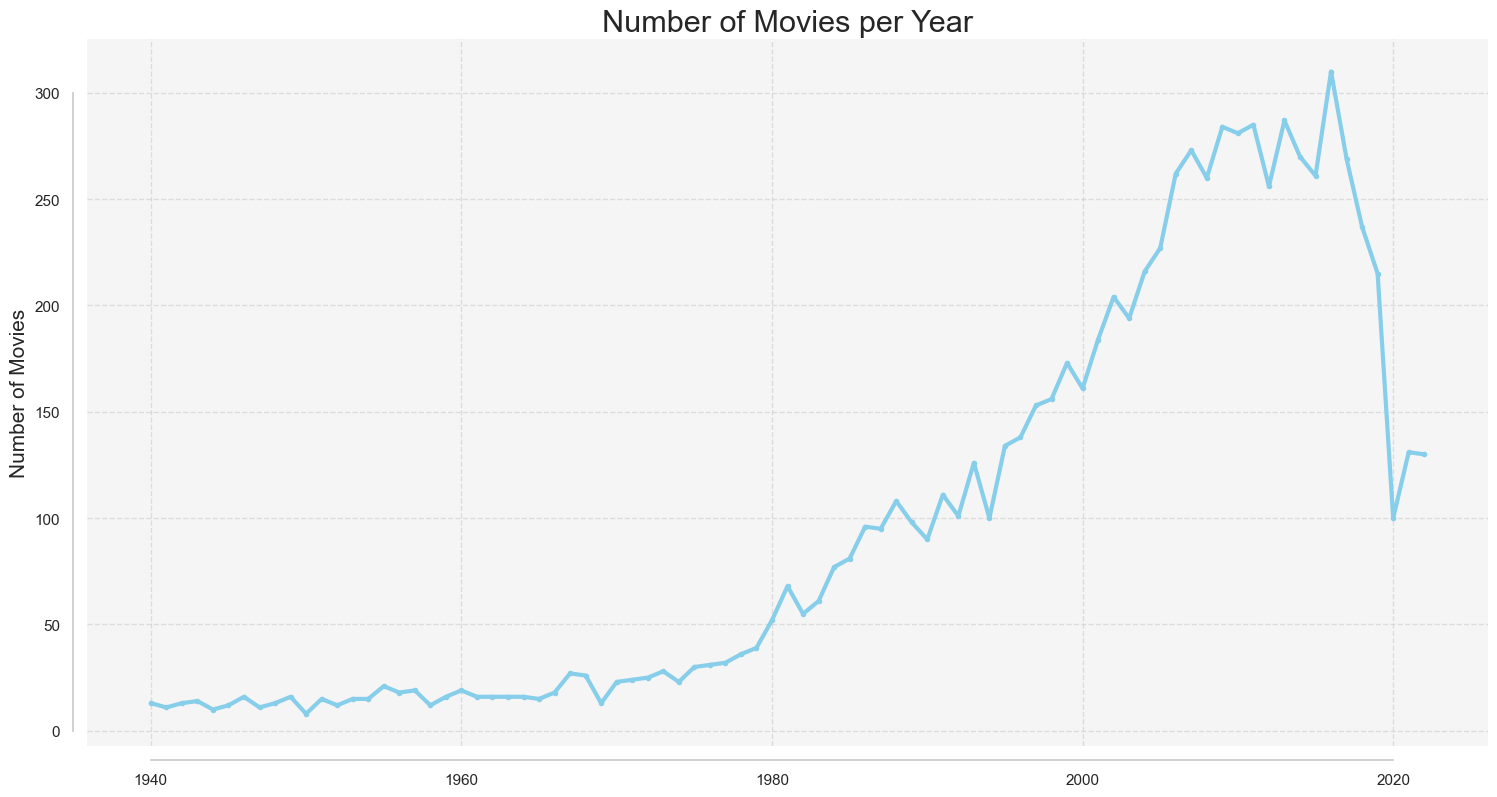

In [22]:
plt.figure(figsize=(15, 8))
plt.plot(year_range, nb_movie_year, c='skyblue', lw=3, marker='o', markersize=3)

plt.title('Number of Movies per Year', fontsize=22)
plt.ylabel('Number of Movies', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

sns.despine(offset=10, trim=True)

plt.show()

Over the years, the film industry has continually expanded, experiencing a noticeable downturn during and after the pandemic.

In [23]:
month_range = [x for x in range(1, 13)]
               
month_name = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
               
nb_movie_month = df.groupby('release_month').size()

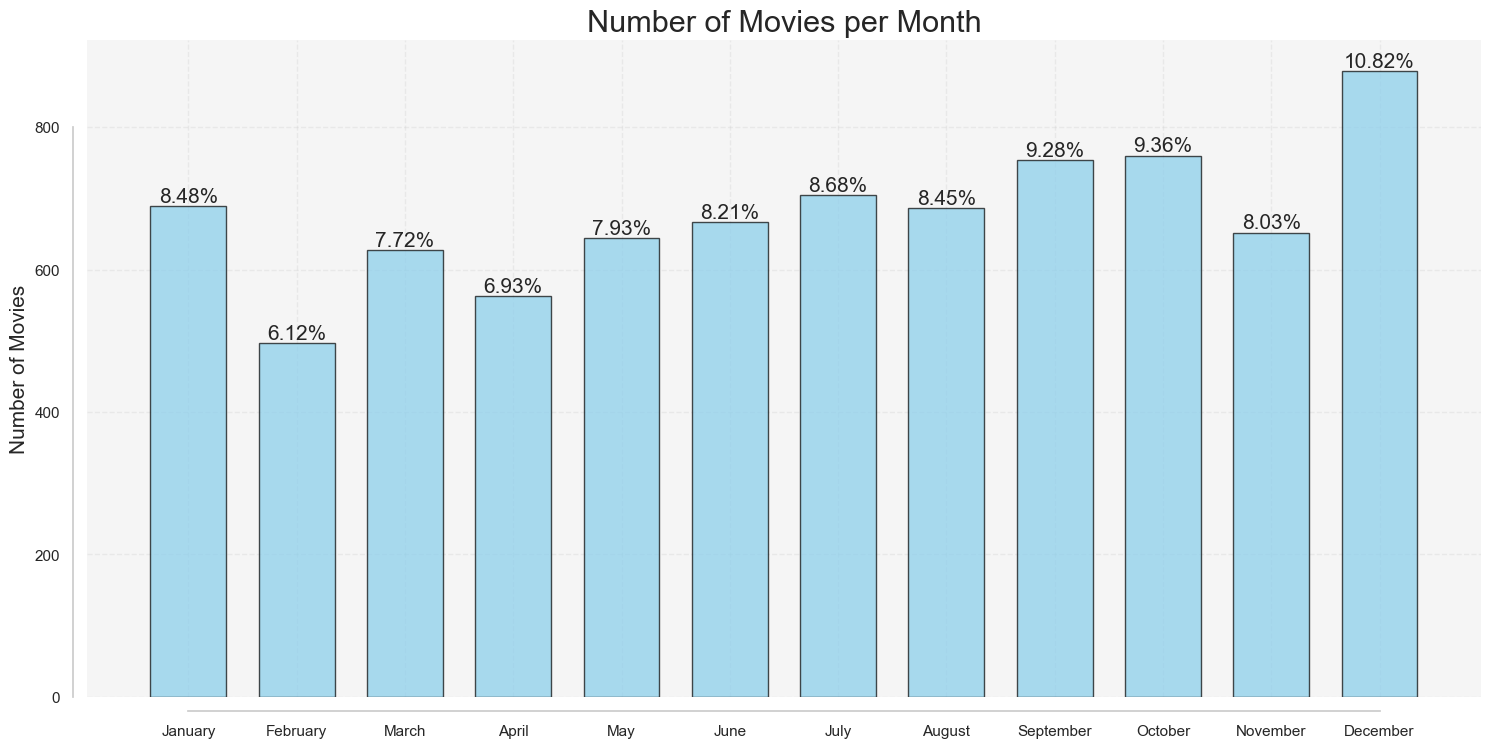

In [24]:
plt.figure(figsize=(15, 8))
plt.bar(month_range, nb_movie_month, color='skyblue', edgecolor='black', width=0.7, alpha=0.7)

plt.title('Number of Movies per Month', fontsize=22)
plt.ylabel('Number of Movies', fontsize=15)
plt.xticks(month_range, month_name, rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')

total_genre = sum(nb_movie_month)
for i, value in enumerate(nb_movie_month):
    percentage = (value / total_genre) * 100
    plt.text(i+1, value, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=15)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

In [25]:
revenue_month = []

for month in month_range:
    revenue_month.append(df.loc[df['release_month'] == month, 'revenue'].mean())

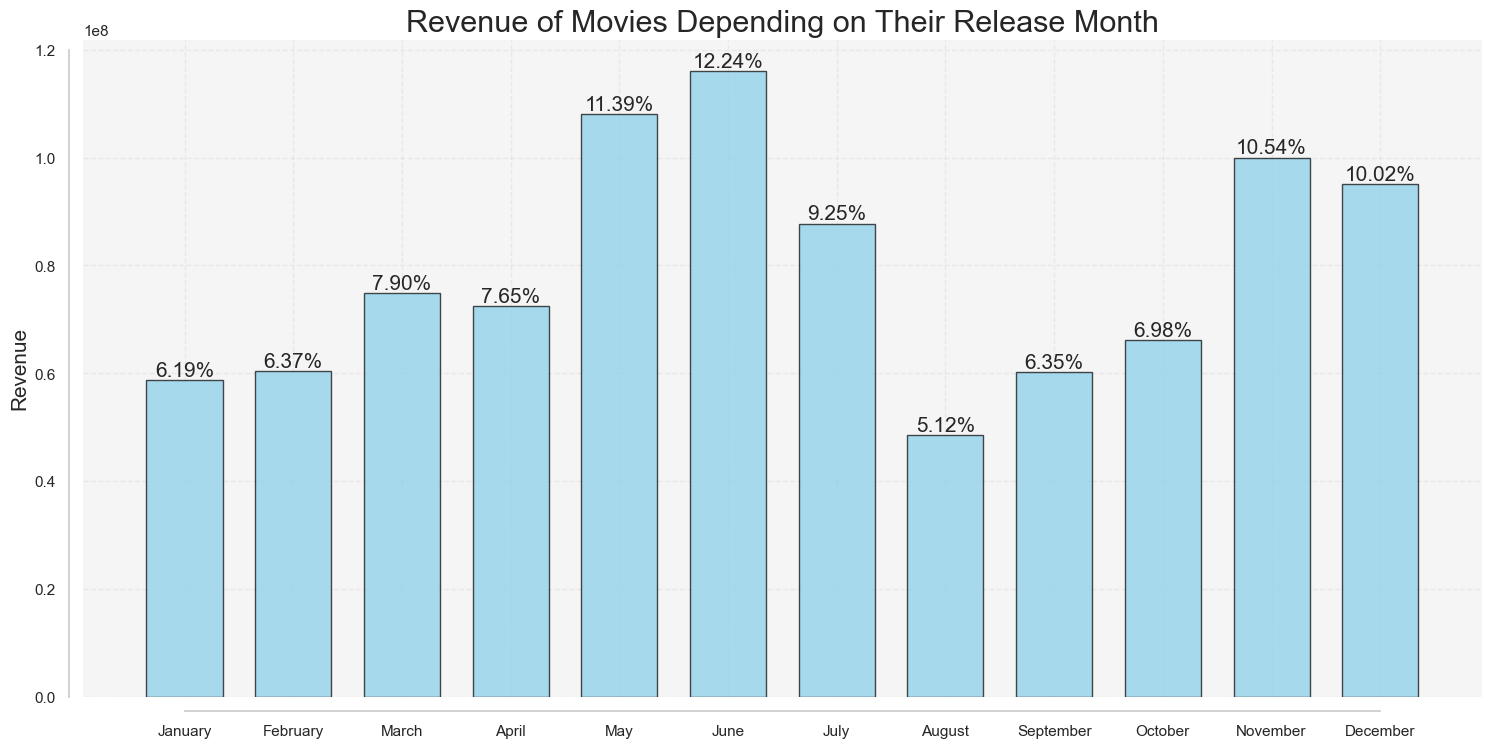

In [26]:
plt.figure(figsize=(15, 8))
plt.bar(month_range, revenue_month, color='skyblue', edgecolor='black', width=0.7, alpha=0.7)

plt.title('Revenue of Movies Depending on Their Release Month', fontsize=22)
plt.ylabel('Revenue', fontsize=15)
plt.xticks(month_range, month_name, rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_facecolor('whitesmoke')

total_revenue_month = sum(revenue_month)
for i, value in enumerate(revenue_month):
    percentage = (value / total_revenue_month) * 100
    plt.text(i+1, value, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=15)

plt.tight_layout()
sns.despine(offset=10, trim=True)

plt.show()

In this database, it appears that films with the highest revenue tend to be released in May and June, following the Cannes Film Festival, as well as at the end of the year, particularly in November and December.

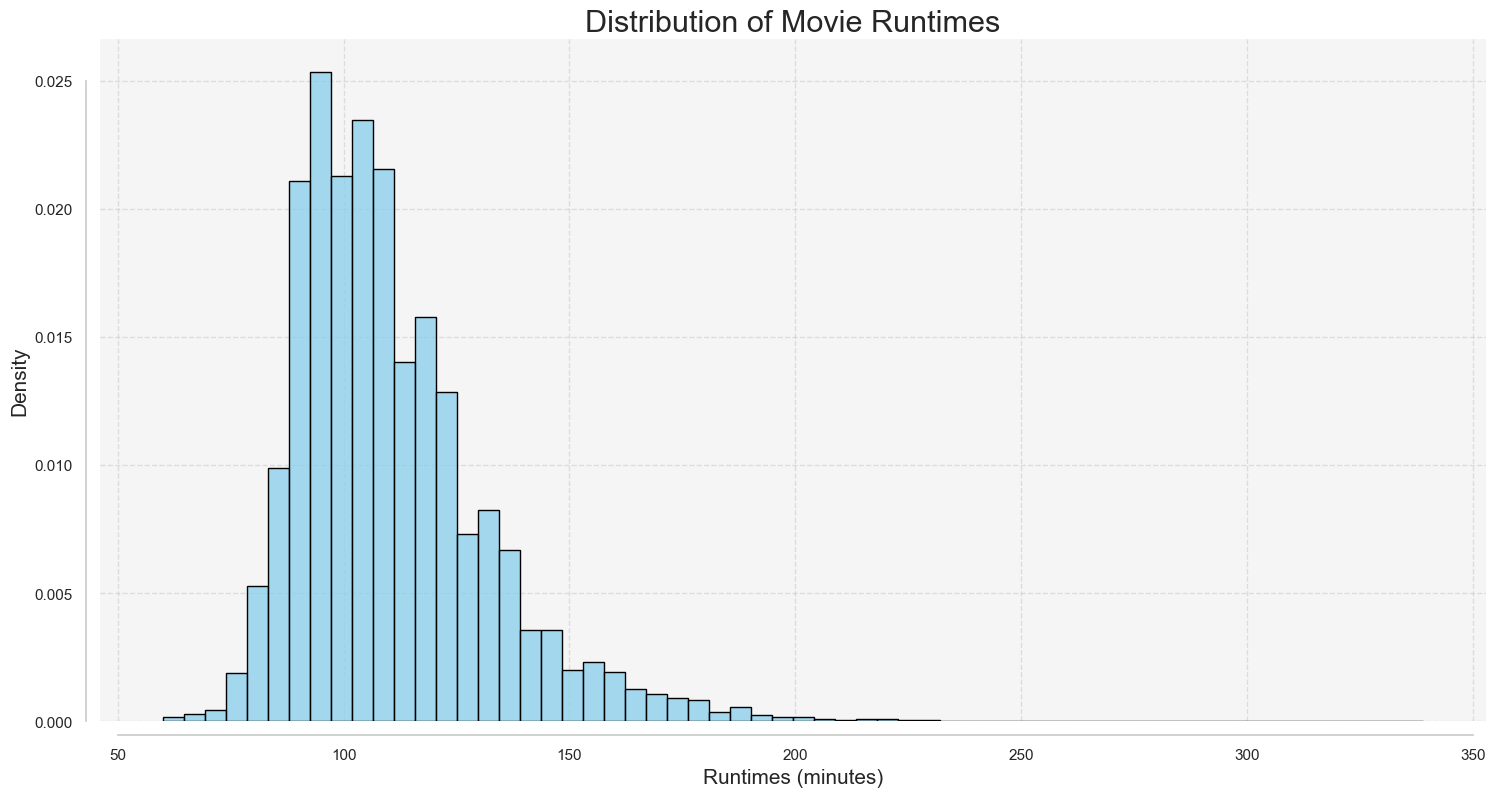

In [27]:
plt.figure(figsize=(15, 8))

sns.histplot(df, x='runtime', stat='density', color='skyblue', edgecolor='black', bins=60, label='runtime distribution')

plt.title('Distribution of Movie Runtimes', fontsize=22)
plt.xlabel('Runtimes (minutes)', fontsize=15)
plt.ylabel('Density', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

sns.despine(offset=10, trim=True)

plt.show()

In [28]:
decade_range = [x for x in range(min(year_range), max(year_range), 10)]
decade_name = [f'{x}-{x + 10}' for x in range(min(year_range), max(year_range), 10)]

runtime_decade = []
runtime_decade_median = []
for year in range(min(year_range), max(year_range), 10):
    runtime_decade.append(df.loc[years.between(year, year + 10), 'runtime'].mean())
    runtime_decade_median.append(df.loc[years.between(year, year + 10), 'runtime'].median())

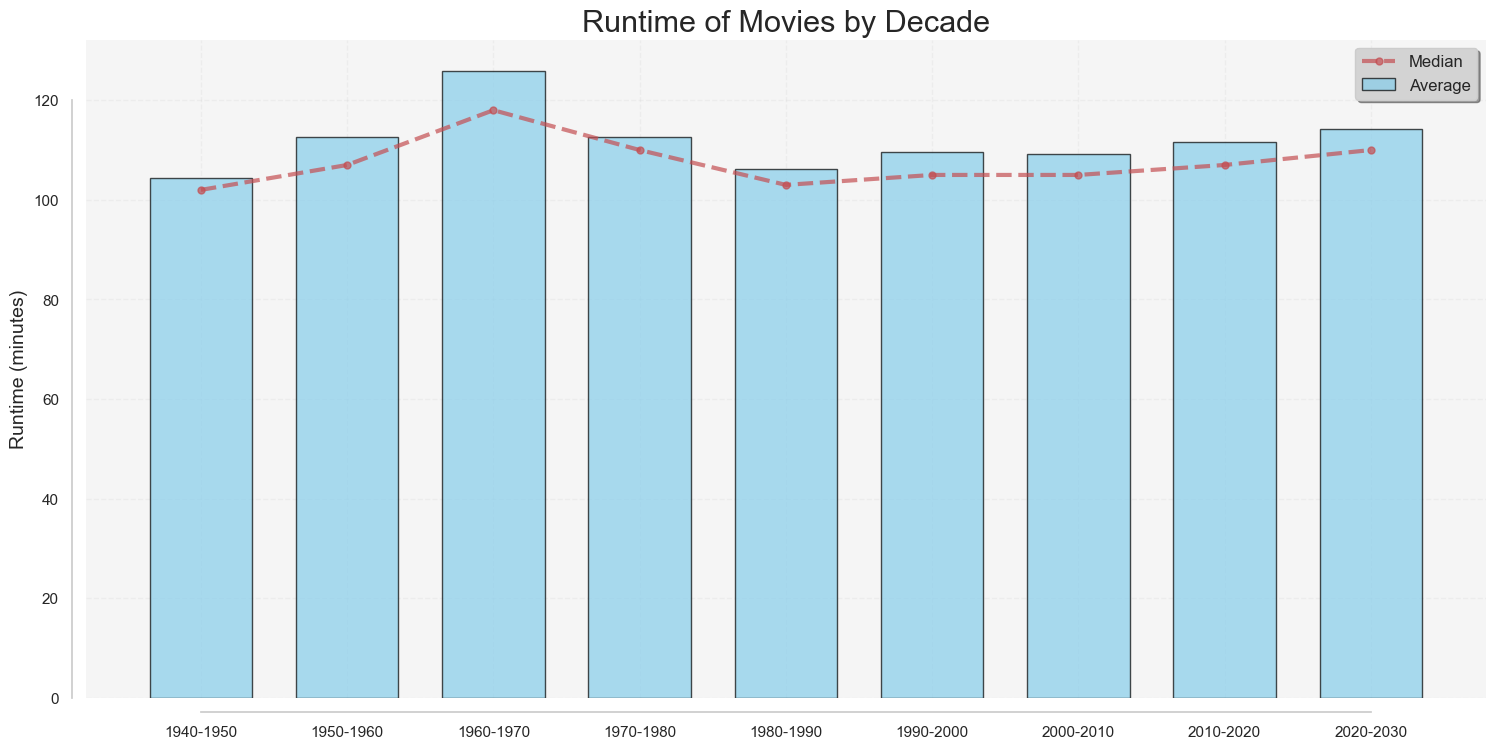

In [29]:
plt.figure(figsize=(15, 8))
plt.bar(decade_range, runtime_decade, color='skyblue', edgecolor='black', width=7, alpha=0.7, label='Average')
plt.plot(decade_range, runtime_decade_median, lw=3, marker="o", markersize=5, alpha=0.7, c='r', label='Median', ls='--')

plt.title('Runtime of Movies by Decade', fontsize=22)
plt.ylabel('Runtime (minutes)', fontsize=14)
plt.xticks(decade_range, decade_name, rotation=30, fontsize=14)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')

plt.tight_layout()
plt.legend(fontsize=12, shadow=True, facecolor='lightgray')
sns.despine(offset=10, trim=True)

plt.show()

Contrary to what I assumed, the runtime of films hasn't changed significantly. I would have expected the opposite since I have the impression that nowadays, all films are at least two and a half hours long.

In [30]:
budget_year = df.groupby('release_year')['budget'].mean()
budget_year_median = df.groupby('release_year')['budget'].median()

act_budget_year = df.groupby('release_year')['act_budget'].mean()
act_budget_year_median = df.groupby('release_year')['act_budget'].median()

budget_all_time_mean = df['budget'].mean()
act_budget_all_time_mean = df['act_budget'].mean()

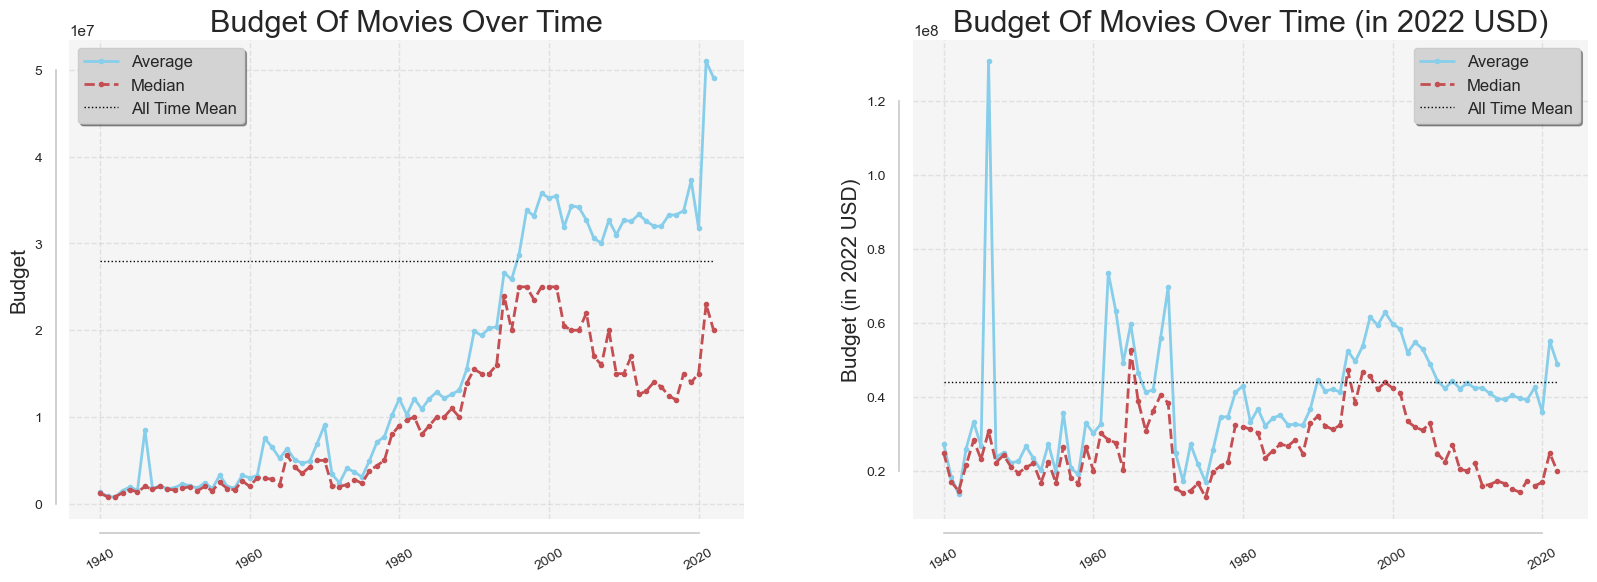

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(year_range, budget_year, lw=2, marker="o", markersize=3, c='skyblue', label='Average')
ax1.plot(year_range, budget_year_median, lw=2, marker="o", markersize=3, c='r', label='Median', ls='--')
ax1.plot(year_range, [budget_all_time_mean]*len(year_range), lw=1, c='black', label='All Time Mean', ls=':')

ax1.set_title('Budget Of Movies Over Time', fontsize=22)
ax1.set_ylabel('Budget', fontsize=15)

ax1.tick_params(axis='x', labelrotation=30)
ax1.tick_params(axis='both', labelsize=10)

ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_facecolor('whitesmoke')
ax1.legend(fontsize=12, shadow=True, facecolor='lightgray')



ax2.plot(year_range, act_budget_year, lw=2, marker="o", markersize=3, c='skyblue', label='Average')
ax2.plot(year_range, act_budget_year_median, lw=2, marker="o", markersize=3, c='r', label='Median',
             ls='--')
ax2.plot(year_range, [act_budget_all_time_mean]*len(year_range), lw=1, c='black', label='All Time Mean', ls=':')

ax2.set_title('Budget Of Movies Over Time (in 2022 USD)', fontsize=22)
ax2.set_ylabel('Budget (in 2022 USD)', fontsize=15)

ax2.tick_params(axis='x', labelrotation=30)
ax2.tick_params(axis='both', labelsize=10)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_facecolor('whitesmoke')
ax2.legend(fontsize=12, shadow=True, facecolor='lightgray')


plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
sns.despine(offset=10, trim=True)

plt.show()

In [32]:
df.loc[df['release_year'] == act_budget_year.idxmax(), 'act_budget']

1120     4.887158e+07
2942     3.073684e+07
4193     2.458947e+07
5863     3.227368e+07
6245     1.589095e+09
6296     3.073684e+07
7883     3.073684e+07
9048     2.586505e+07
10322    3.265789e+07
11431    1.152632e+07
14710    9.221053e+07
20152    1.576800e+07
30245    2.526568e+07
31933    4.429179e+07
47984    5.096168e+07
75361    6.562316e+06
Name: act_budget, dtype: float64

In [33]:
df= df.drop(6245)

It appears that there is an extreme value in the data. Once identified, we remove it from the dataset.

In [34]:
budget_year = df.groupby('release_year')['budget'].mean()
budget_year_median = df.groupby('release_year')['budget'].median()

act_budget_year = df.groupby('release_year')['act_budget'].mean()
act_budget_year_median = df.groupby('release_year')['act_budget'].median()

budget_all_time_mean = df['budget'].mean()
act_budget_all_time_mean = df['act_budget'].mean()

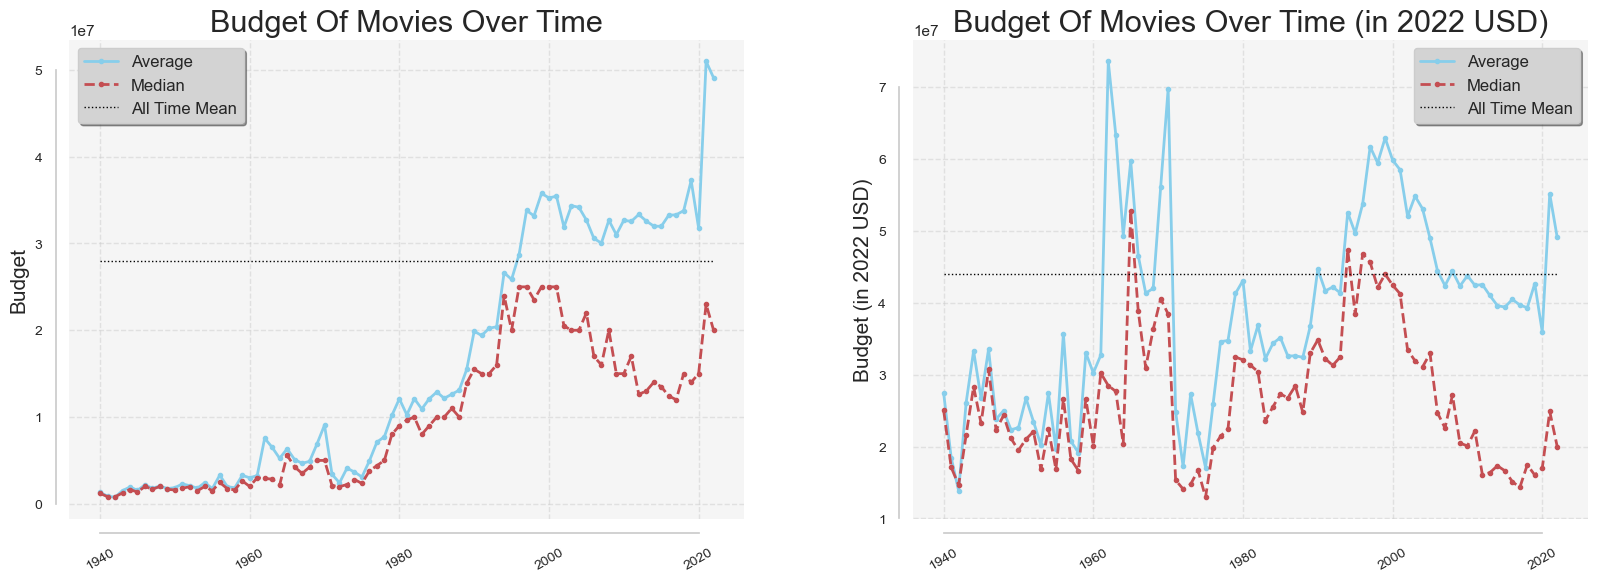

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(year_range, budget_year, lw=2, marker="o", markersize=3, c='skyblue', label='Average')
ax1.plot(year_range, budget_year_median, lw=2, marker="o", markersize=3, c='r', label='Median', ls='--')
ax1.plot(year_range, [budget_all_time_mean]*len(year_range), lw=1, c='black', label='All Time Mean', ls=':')

ax1.set_title('Budget Of Movies Over Time', fontsize=22)
ax1.set_ylabel('Budget', fontsize=15)

ax1.tick_params(axis='x', labelrotation=30)
ax1.tick_params(axis='both', labelsize=10)

ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_facecolor('whitesmoke')
ax1.legend(fontsize=12, shadow=True, facecolor='lightgray')



ax2.plot(year_range, act_budget_year, lw=2, marker="o", markersize=3, c='skyblue', label='Average')
ax2.plot(year_range, act_budget_year_median, lw=2, marker="o", markersize=3, c='r', label='Median',
             ls='--')
ax2.plot(year_range, [act_budget_all_time_mean]*len(year_range), lw=1, c='black', label='All Time Mean', ls=':')

ax2.set_title('Budget Of Movies Over Time (in 2022 USD)', fontsize=22)
ax2.set_ylabel('Budget (in 2022 USD)', fontsize=15)

ax2.tick_params(axis='x', labelrotation=30)
ax2.tick_params(axis='both', labelsize=10)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_facecolor('whitesmoke')
ax2.legend(fontsize=12, shadow=True, facecolor='lightgray')


plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
sns.despine(offset=10, trim=True)

plt.show()

Of course, budget of movies has increased over years but when we convert money of past years in money on current time (2022 USD), we observe peaks in 1960s and 1970s that are higher that the current spending for films.

This could be explain by technological advancements. The 1960s and 1970s were marked by significant advancements in film technology, such as the widespread adoption of color and improvements in special effects. This could have increased production costs.

In [36]:
revenue_year = df.groupby('release_year')['revenue'].mean()
revenue_year_median = df.groupby('release_year')['revenue'].median()

act_revenue_year = df.groupby('release_year')['act_revenue'].mean()
act_revenue_year_median = df.groupby('release_year')['act_revenue'].median()

revenue_all_time_mean = df['revenue'].mean()
act_revenue_all_time_mean = df['act_revenue'].mean()

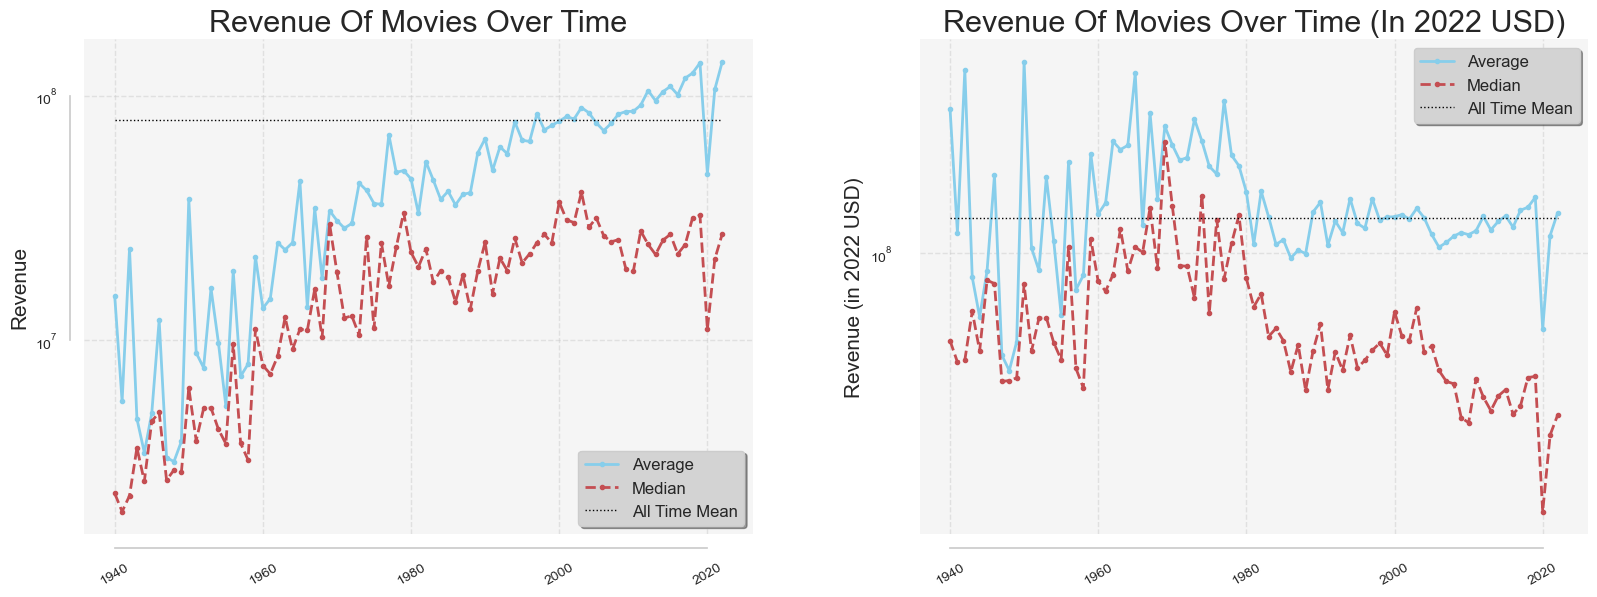

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(year_range, revenue_year, lw=2, marker="o", markersize=3, c='skyblue', label='Average')
ax1.plot(year_range, revenue_year_median, lw=2, marker="o", markersize=3, c='r', label='Median', ls='--')
ax1.plot(year_range, [revenue_all_time_mean] * len(year_range), lw=1, c='black', label='All Time Mean', ls=':')

ax1.set_title('Revenue Of Movies Over Time', fontsize=22)
ax1.set_ylabel('Revenue', fontsize=15)

ax1.tick_params(axis='x', labelrotation=30)
ax1.tick_params(axis='both', labelsize=10)

ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_facecolor('whitesmoke')
ax1.legend(fontsize=12, shadow=True, facecolor='lightgray')
ax1.set_yscale('log')

ax2.plot(year_range, act_revenue_year, lw=2, marker="o", markersize=3, c='skyblue', label='Average')
ax2.plot(year_range, act_revenue_year_median, lw=2, marker="o", markersize=3, c='r', label='Median', ls='--')
ax2.plot(year_range, [act_revenue_all_time_mean] * len(year_range), lw=1, c='black', label='All Time Mean', ls=':')

ax2.set_title('Revenue Of Movies Over Time (In 2022 USD)', fontsize=22)
ax2.set_ylabel('Revenue (in 2022 USD)', fontsize=15)

ax2.tick_params(axis='x', labelrotation=30)
ax2.tick_params(axis='both', labelsize=10)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_facecolor('whitesmoke')
ax2.legend(fontsize=12, shadow=True, facecolor='lightgray')
ax2.set_yscale('log')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
sns.despine(offset=10, trim=True)

plt.show()

Once the inflationary effect is removed, it becomes apparent that since 1980, the median revenue of films has exhibited a more stable trend (excluding the pandemic years). However, the overall trend is decreasing even if we stay around the all time mean revenue.

In [38]:
rentability_year_median = df.groupby('release_year')['rentability'].median()

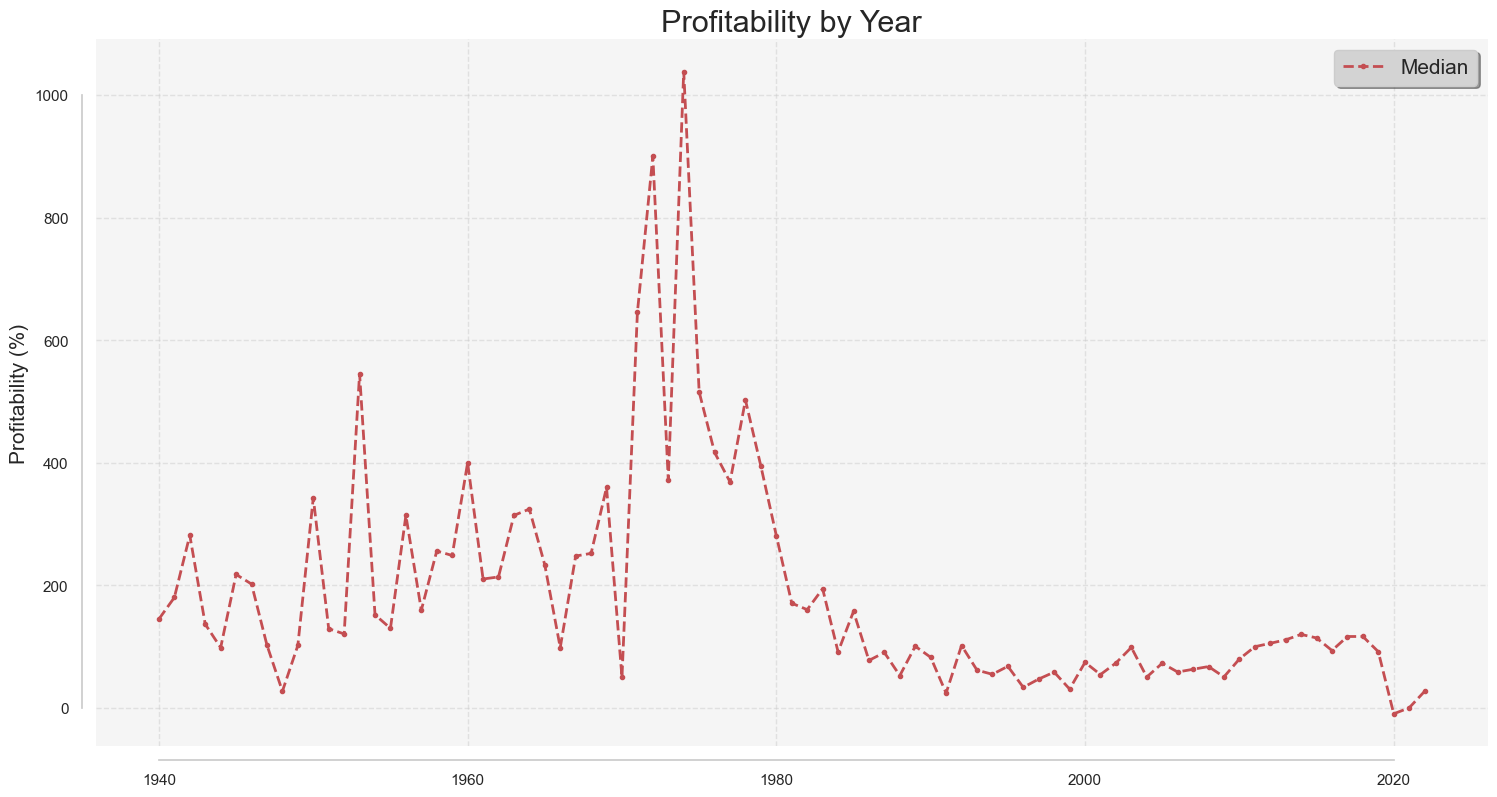

In [39]:
plt.figure(figsize=(15, 8))

plt.plot(year_range, rentability_year_median, lw=2, marker="o", markersize=3, c='r', label='Median', ls='--')

plt.title('Profitability by Year', fontsize=22)
plt.ylabel('Profitability (%)', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.legend(fontsize=15, shadow=True, facecolor='lightgray')
sns.despine(offset=10, trim=True)

plt.show()

In [40]:
df_recent = df.query('release_year >= 2000')

year_range_recent = [year for year in year_range if year >= 2000]

In [41]:
rentability_year_median_recent = df_recent.groupby('release_year')['rentability'].median()
rentability_year_recent = df_recent.groupby('release_year')['rentability'].mean()

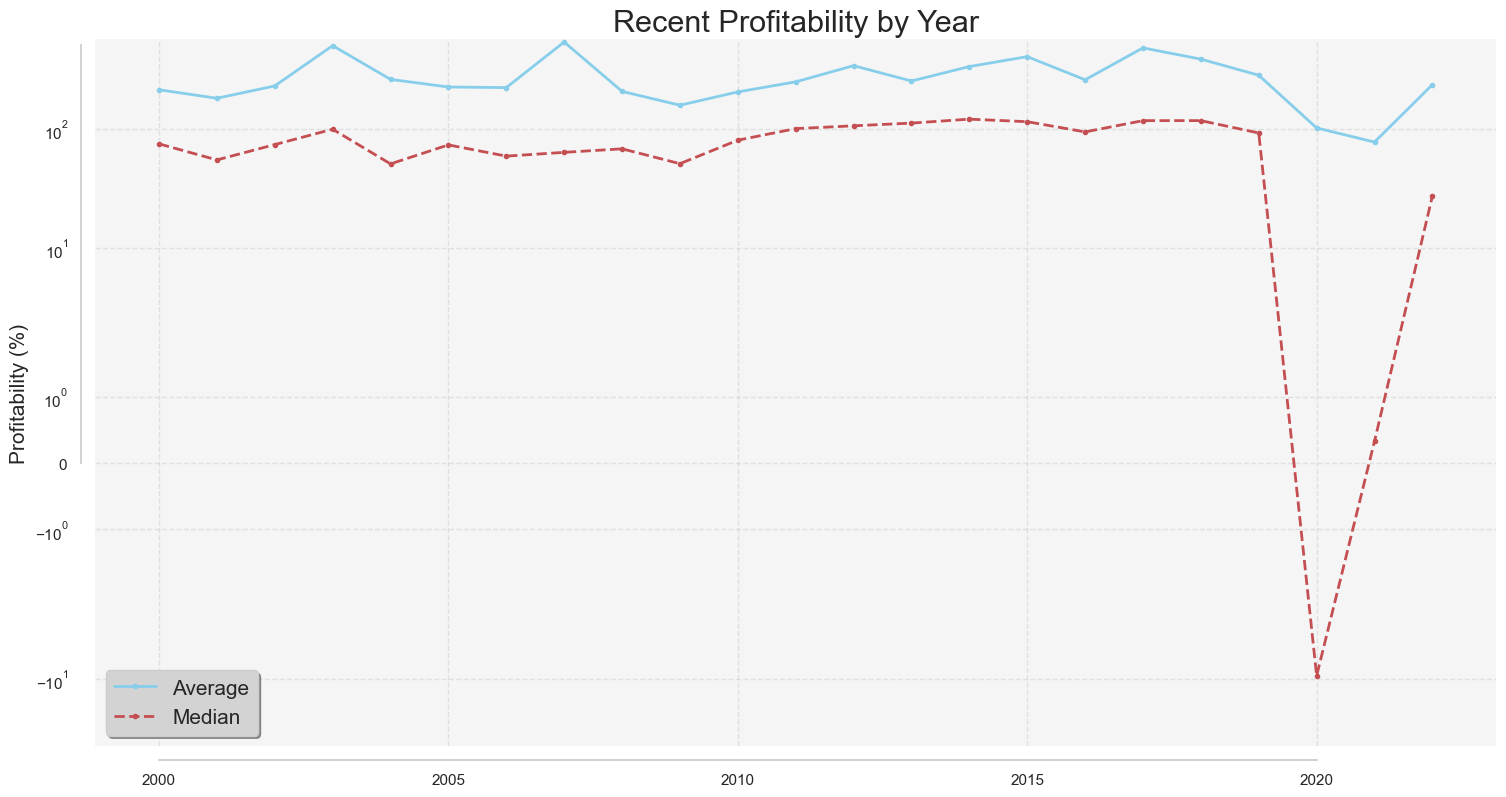

In [42]:
plt.figure(figsize=(15, 8))

plt.plot(year_range_recent, rentability_year_recent, lw=2, marker="o", markersize=3, c='skyblue', label='Average')
plt.plot(year_range_recent, rentability_year_median_recent, lw=2, marker="o", markersize=3, c='r', label='Median', ls='--')

plt.title('Recent Profitability by Year', fontsize=22)
plt.ylabel('Profitability (%)', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.legend(fontsize=15, shadow=True, facecolor='lightgray')
sns.despine(offset=10, trim=True)

plt.yscale('symlog')

plt.show()

Due to the pandemic, a historic shift occurred for the first time in history, where, during a specific year, there were more movies with higher budgets than revenue than movies with higher revenue than budget.

In [43]:
genres_column_str = [f'{x}' for x in df['genres']]
ch_genres = ','.join(list(genres_column_str)).replace(", ", ",")
genres_list = ch_genres.split(',')
genres_name = list(set(genres_list))


nb_per_genre = []

for genre in genres_name:
    nb_per_genre.append(genres_list.count(genre))

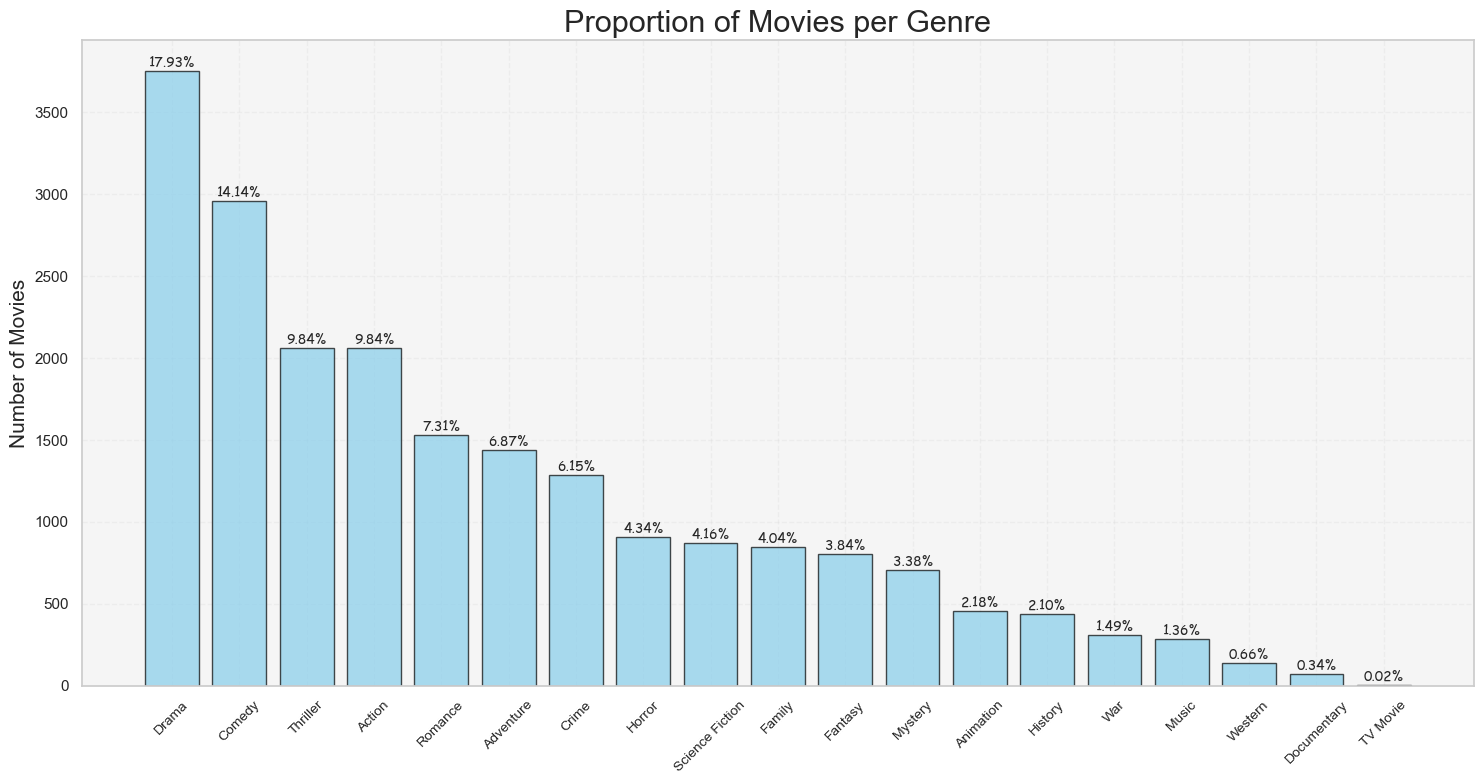

In [44]:
sorted_NbGenre_name = sorted(zip(nb_per_genre, genres_name), reverse=True)
nb_per_genre_sorted, genres_name_sorted = zip(*sorted_NbGenre_name)

plt.figure(figsize=(15, 8))

plt.bar(genres_name_sorted, nb_per_genre_sorted, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Proportion of Movies per Genre', fontsize=22)
plt.ylabel('Number of Movies', fontsize=15)

plt.xticks(genres_name_sorted, genres_name_sorted, rotation=45, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')

total_genre = sum(nb_per_genre_sorted)
for i, value in enumerate(nb_per_genre_sorted):
    percentage = (value / total_genre) * 100
    plt.text(i, value, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10, family='cursive')

plt.tight_layout()
plt.show()

In this database, the genre that appears most frequently is drama, accounting for nearly 18% of the movies.

In [45]:
popularity_genre = []

for genre in genres_name:
    popularity_genre.append(df.loc[df['genres'].str.contains(genre), 'popularity'].mean())

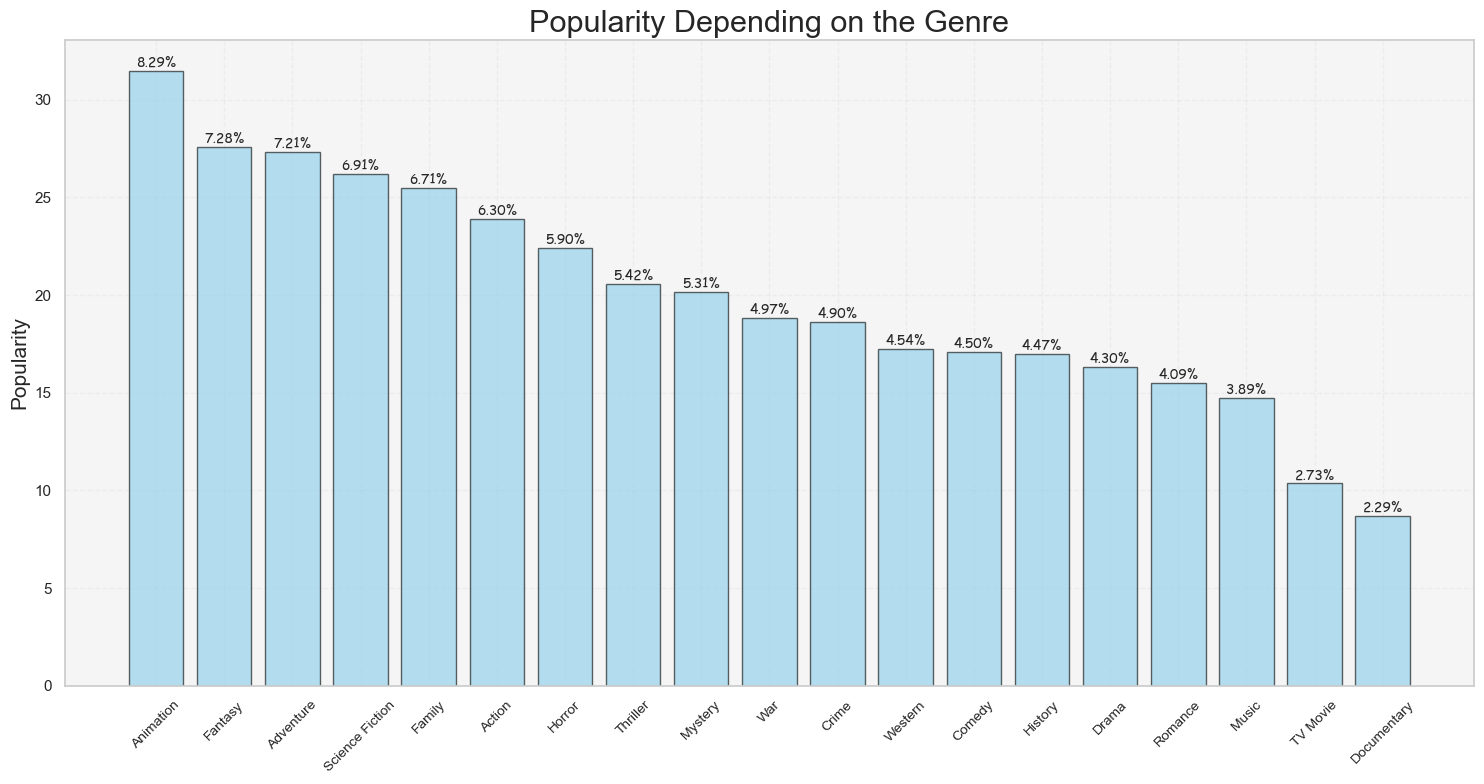

In [46]:
sorted_PopGenre_name = sorted(zip(popularity_genre, genres_name), reverse=True)
popularity_genre_sorted, genres_name_sorted = zip(*sorted_PopGenre_name)

plt.figure(figsize=(15, 8))

plt.bar(genres_name_sorted, popularity_genre_sorted, color='skyblue', edgecolor='black', alpha=0.6)

plt.title('Popularity Depending on the Genre', fontsize=22)
plt.ylabel('Popularity', fontsize=15)

plt.xticks(genres_name_sorted, genres_name_sorted, rotation=45, fontsize=10)
    
plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')

total_popularity = sum(popularity_genre_sorted)
for i, value in enumerate(popularity_genre_sorted):
    percentage = (value / total_popularity) * 100
    plt.text(i, value, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10, family='cursive')

plt.tight_layout()

plt.show()

Popular genres are those that have a broad appeal, captivating both adults and children alike.

In [47]:
rentability_genre = []

for genre in genres_name:
    rentability_genre.append(df.loc[df['genres'].str.contains(genre), 'rentability'].mean())

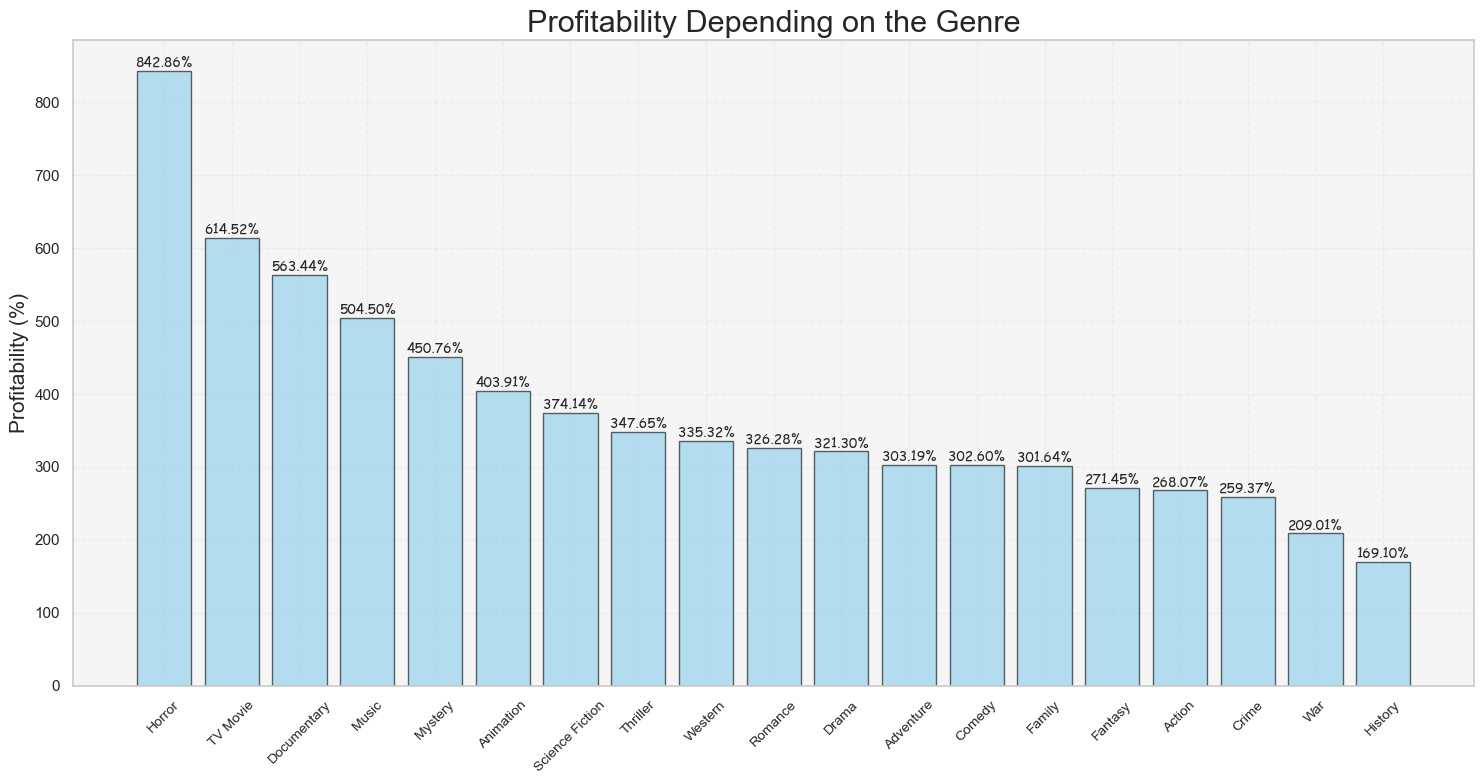

In [48]:
sorted_RentabilityGenre_name = sorted(zip(rentability_genre, genres_name), reverse=True)
rentability_genre_sorted, genres_name_sorted = zip(*sorted_RentabilityGenre_name)

plt.figure(figsize=(15, 8))

plt.bar(genres_name_sorted, rentability_genre_sorted, color='skyblue', edgecolor='black', alpha=0.6)

plt.title('Profitability Depending on the Genre', fontsize=22)
plt.ylabel('Profitability (%)', fontsize=15)

plt.xticks(genres_name_sorted, genres_name_sorted, rotation=45, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')

for i, value in enumerate(rentability_genre_sorted):
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10, family='cursive')
    
plt.tight_layout()

plt.show()

The observation that the most lucrative genres, namely horror, TV movies, and documentaries, do not necessarily align with the most popular genres suggests that their profitability may be attributed to the relatively lower production costs associated with these types of films. 

In [49]:
spoklang_column_str = [f'{x}' for x in df['spoken_languages']]
ch_spoklang = ','.join(list(spoklang_column_str)).replace(", ", ",")
spoklang_list = ch_spoklang.split(',')
spoklang_name = list(set(spoklang_list))

nb_per_spoklang = []
for lang in spoklang_name:
    nb_per_spoklang.append(spoklang_list.count(lang))

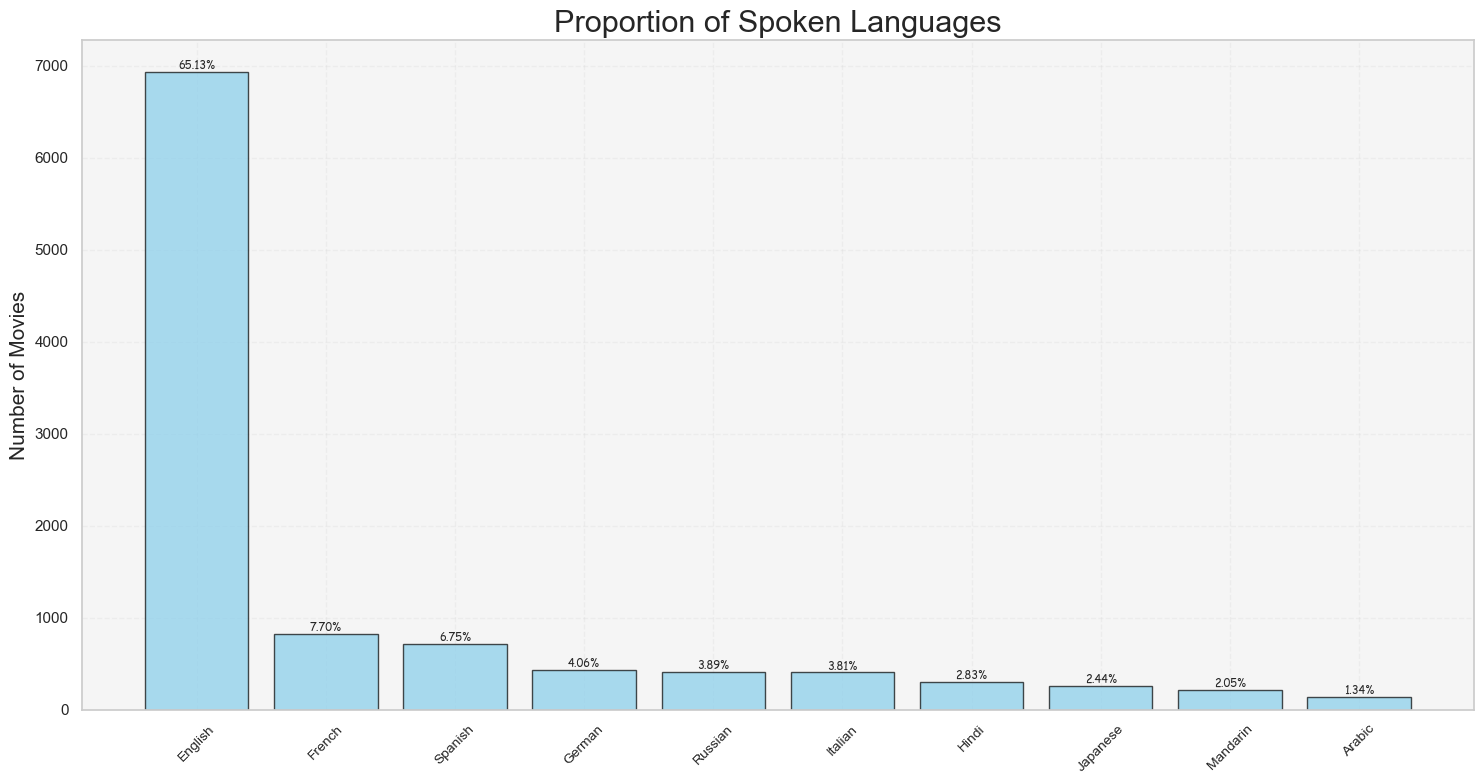

In [50]:
sorted_Nbspoklang_name = sorted(zip(nb_per_spoklang, spoklang_name), reverse=True)
sorted_Nbspoklang_name_short = sorted_Nbspoklang_name[0:10]
nb_per_spoklang_sorted, spoklang_name_sorted = zip(*sorted_Nbspoklang_name_short)

plt.figure(figsize=(15, 8))

plt.bar(spoklang_name_sorted, nb_per_spoklang_sorted, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Proportion of Spoken Languages', fontsize=22)
plt.ylabel('Number of Movies', fontsize=15)

plt.xticks(spoklang_name_sorted, spoklang_name_sorted, rotation=45, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')

total_spoklang = sum(nb_per_spoklang_sorted)
for i, value in enumerate(nb_per_spoklang_sorted):
    percentage = (value / total_spoklang) * 100
    plt.text(i, value, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8, family='cursive')

plt.tight_layout()
plt.show()

In [51]:
pcompanies_column_str = [f'{x}' for x in df['production_companies']]
ch_pcompanies = ','.join(list(pcompanies_column_str)).replace(", ", ",")
pcompanies_list = ch_pcompanies.split(',')
pcompanies_name = list(set(pcompanies_list))

nb_per_pcompanies = []
for companies in spoklang_name:
    nb_per_pcompanies.append(spoklang_list.count(companies))

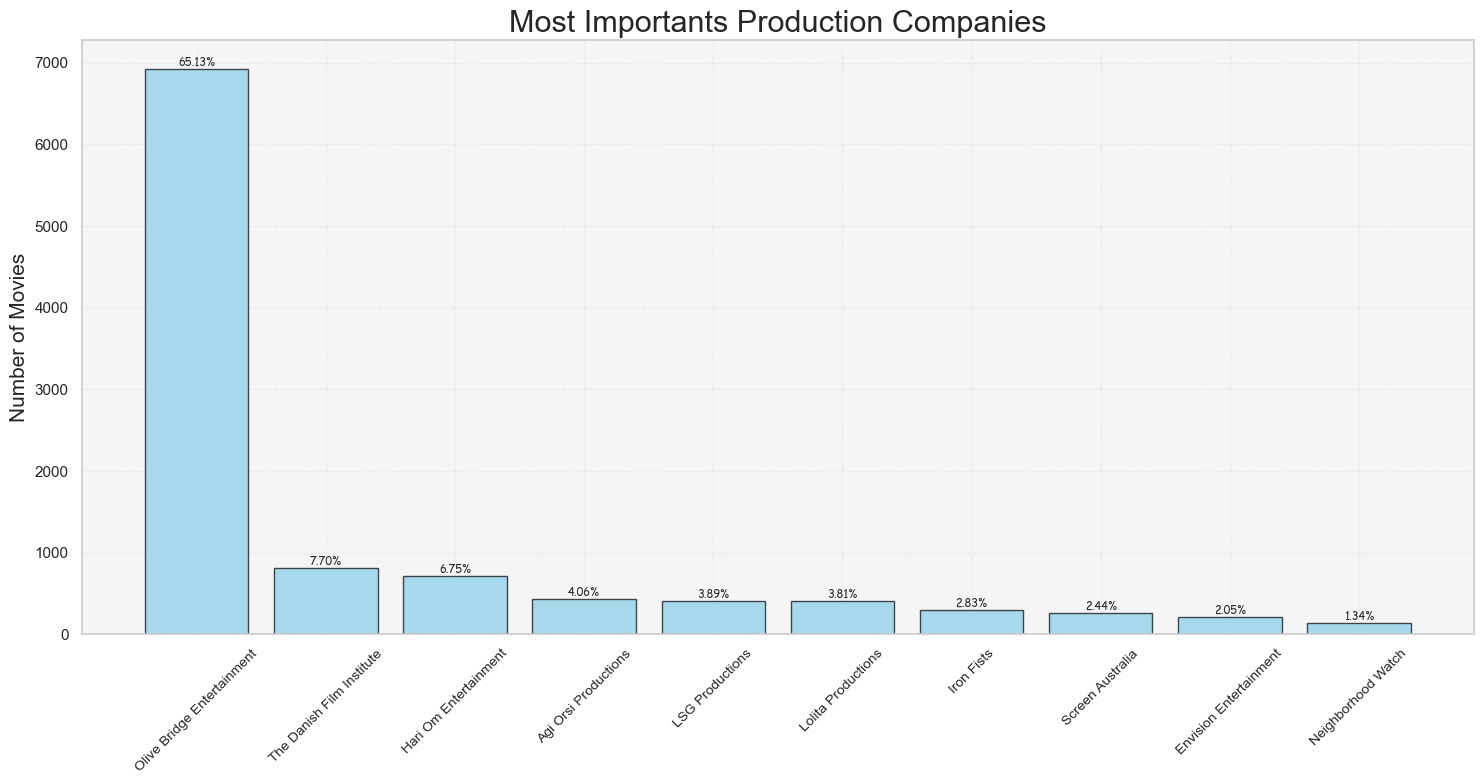

In [52]:
sorted_Nbpcompanies_name = sorted(zip(nb_per_pcompanies, pcompanies_name), reverse=True)
sorted_Nbpcompanies_name_short = sorted_Nbpcompanies_name[0:10]
nb_per_pcompanies_sorted, pcompanies_name_sorted = zip(*sorted_Nbpcompanies_name_short)

plt.figure(figsize=(15, 8))

plt.bar(pcompanies_name_sorted, nb_per_pcompanies_sorted, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Most Importants Production Companies', fontsize=22)
plt.ylabel('Number of Movies', fontsize=15)

plt.xticks(pcompanies_name_sorted, pcompanies_name_sorted, rotation=45, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')

total_pcompanies = sum(nb_per_pcompanies_sorted)
for i, value in enumerate(nb_per_pcompanies_sorted):
    percentage = (value / total_pcompanies) * 100
    plt.text(i, value, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8, family='cursive')

plt.tight_layout()
plt.show()

In [53]:
pcompanies_column_str = [f'{x}' for x in df_recent['production_companies']]
ch_pcompanies = ','.join(list(pcompanies_column_str)).replace(", ", ",")
pcompanies_list = ch_pcompanies.split(',')
pcompanies_name = list(set(pcompanies_list))

nb_per_pcompanies = []
for companies in spoklang_name:
    nb_per_pcompanies.append(spoklang_list.count(companies))

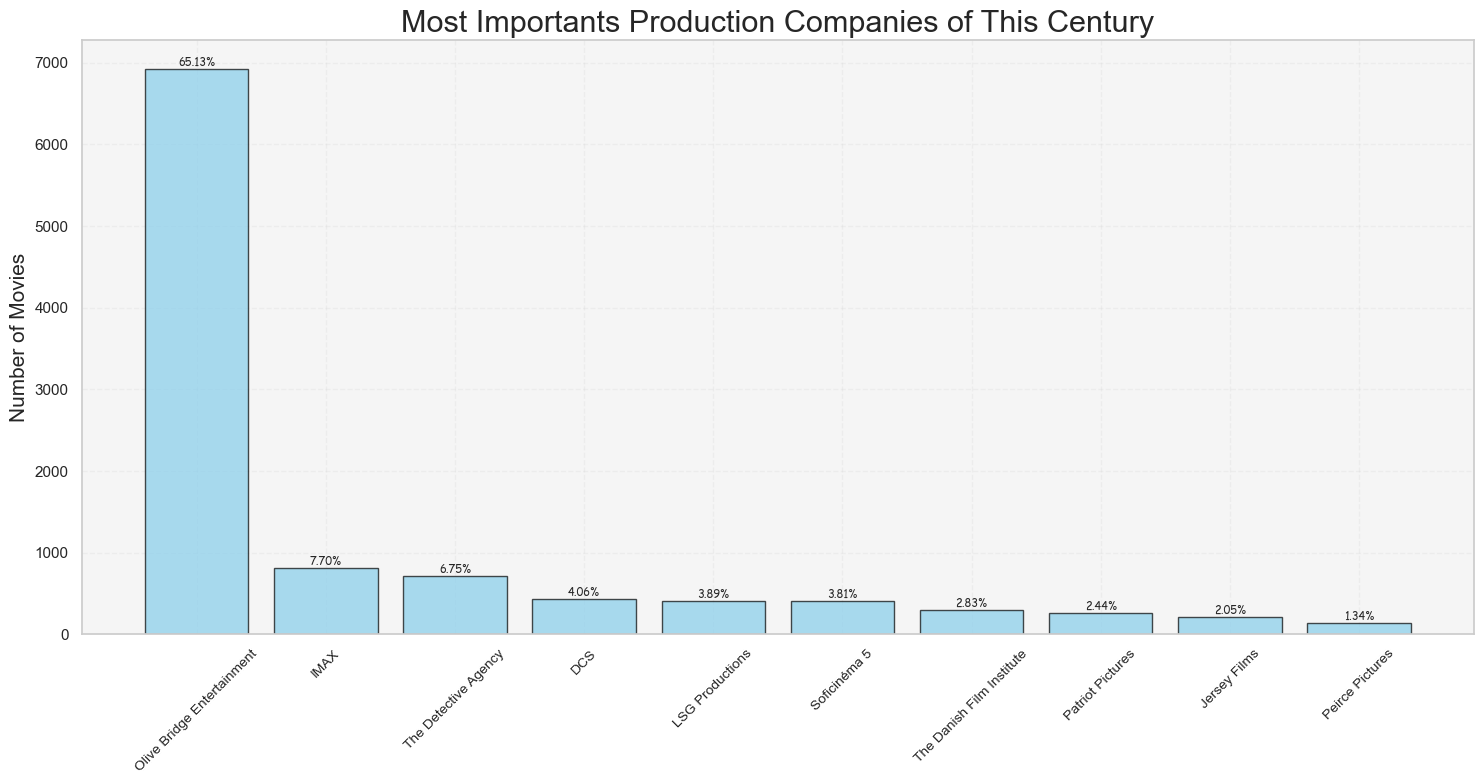

In [54]:
sorted_Nbpcompanies_name = sorted(zip(nb_per_pcompanies, pcompanies_name), reverse=True)
sorted_Nbpcompanies_name_short = sorted_Nbpcompanies_name[0:10]
nb_per_pcompanies_sorted, pcompanies_name_sorted = zip(*sorted_Nbpcompanies_name_short)

plt.figure(figsize=(15, 8))

plt.bar(pcompanies_name_sorted, nb_per_pcompanies_sorted, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Most Importants Production Companies of This Century', fontsize=22)
plt.ylabel('Number of Movies', fontsize=15)

plt.xticks(pcompanies_name_sorted, pcompanies_name_sorted, rotation=45, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')

total_pcompanies = sum(nb_per_pcompanies_sorted)
for i, value in enumerate(nb_per_pcompanies_sorted):
    percentage = (value / total_pcompanies) * 100
    plt.text(i, value, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8, family='cursive')

plt.tight_layout()
plt.show()

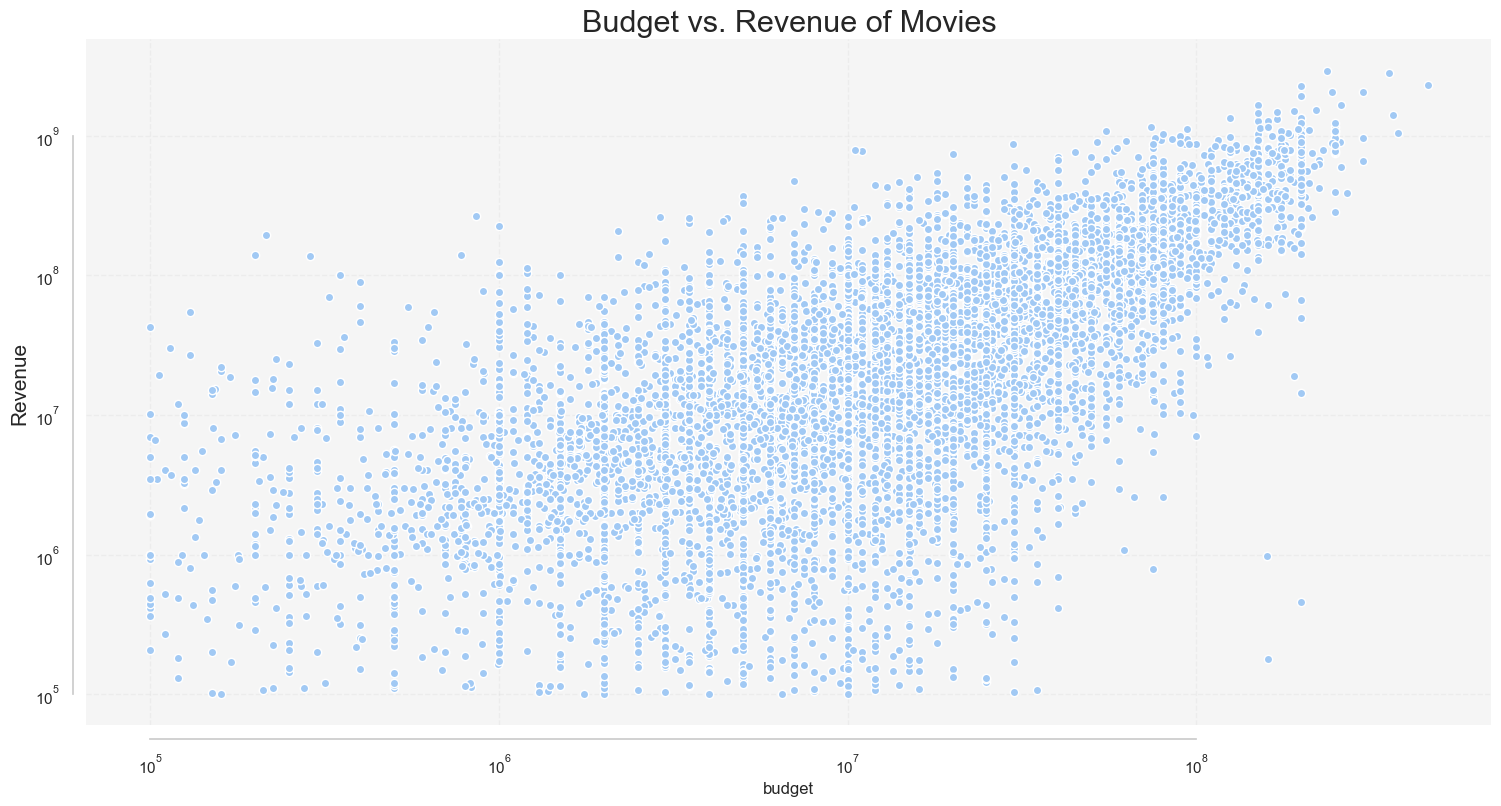

In [55]:
plt.figure(figsize=(15, 8))

sns.scatterplot(x='budget', y='revenue', data=df, linewidth=1)

plt.title('Budget vs. Revenue of Movies', fontsize=22)
plt.ylabel('Budget', fontsize=15)
plt.ylabel('Revenue', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.xscale('log')
plt.yscale('log')

sns.despine(offset=10, trim=True)

plt.show()

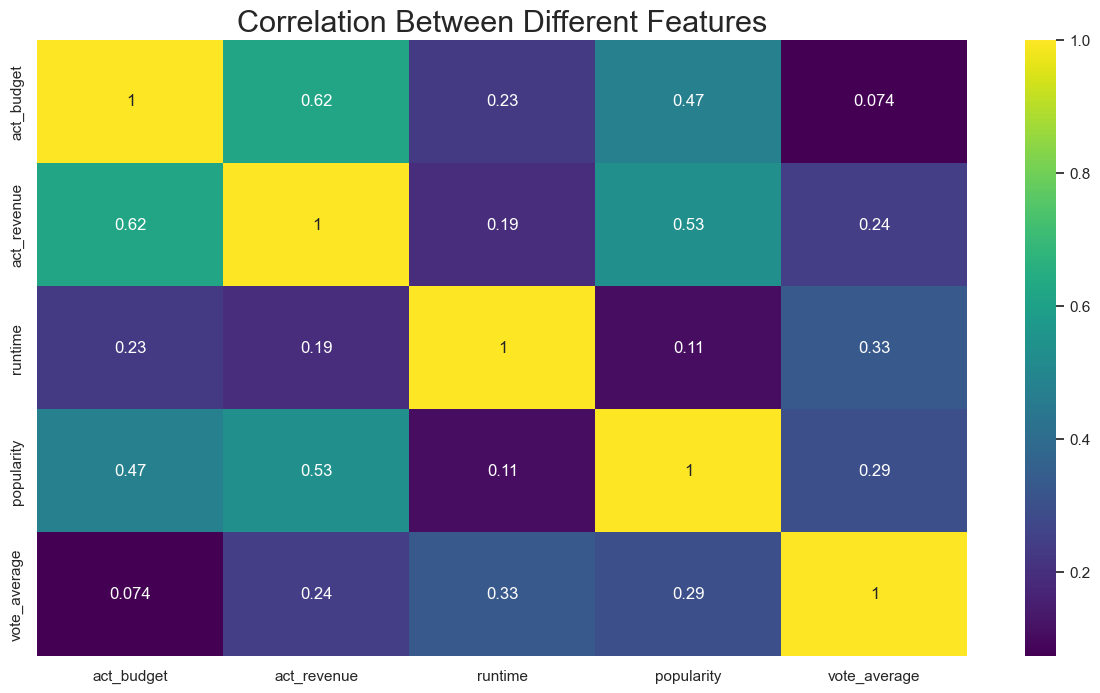

In [56]:
plt.figure(figsize=(15, 8))

sns.heatmap(df[['act_budget', 'act_revenue', 'runtime', 'popularity', 'vote_average']].corr(), annot=True, cmap='viridis')

plt.title('Correlation Between Different Features', fontsize=22)

plt.show()

# 

# 

# PREDICTION OF MOVIE REVENUE

The goal is to see if with the variables we have we can predict how much money a movie will make using different methods.

In [65]:
df_recent = df.query('release_year >= 2000')

x = df_recent[['runtime', 'act_budget', 'genres',
       'spoken_languages']]

y = df_recent['act_revenue']

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [67]:
spoklang_name_sorted = spoklang_name_sorted[0:5]

In [68]:
for genre in genres_name:
    x_train[genre] = x_train['genres'].apply(lambda y: 1 if genre in y else 0)
    
for lang in spoklang_name_sorted:
    x_train[lang] = x_train['spoken_languages'].apply(lambda y: 1 if lang in y else 0)

x_train = x_train.drop(['genres', 'spoken_languages'], axis=1)

In [69]:
for genre in genres_name:
    x_test[genre] = x_test['genres'].apply(lambda x: 1 if genre in x else 0)

for lang in spoklang_name_sorted:
    x_test[lang] = x_test['spoken_languages'].apply(lambda x: 1 if lang in x else 0)

x_test = x_test.drop(['genres', 'spoken_languages'], axis=1)

In [70]:
x_train.head()

,runtime,act_budget,Family,Thriller,Music,Horror,Mystery,Adventure,Western,Science Fiction,Fantasy,TV Movie,Documentary,Crime,Animation,History,Action,Comedy,Drama,War,Romance,English,French,Spanish,German,Russian
267,131,2.013793e+08,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1
3385,66,9.733333e+06,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0
10675,120,2.444651e+07,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0
4073,97,3.882979e+07,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0
11191,116,1.743284e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0


In [ ]:
# Questions : - what can be in the error term ? 
# How to introduce star power ? --> lsit of actor and attribute them a score ? already exist ? --> crew rewarded ?
# How to have data on marketing spending 
# Add dummy variable Receive_Award --> like cannes festival 
# Add realse date 
# Is this the following film of anothe one ? 
# We see it for barbie vs op --> wether a big film released in the same date 
# external data like how cinema is doing 

# No social media analysis because goal is to predict let's say during the investment of teh project 


#The track record of the key talent, including the director, top billed cast, writer, and producers can correlate to box office performance. Their past popularity and awards recognition are useful metrics. Monitoring advance ticket sales across online ticketing platforms can also help forecast opening weekend turnout. Comparing sales to similar titles can give an additional benchmark.

# 

##  Linear Regression

In [71]:
scaler = StandardScaler()

x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.fit_transform(x_test)

reg = LinearRegression()
reg.fit(x_train_s, y_train)

LinearRegression()

In [72]:
reg.score(x_test_s,y_test)

0.6109672340617582

In [73]:
reg.coef_
for i in range(len(x_test.columns)):
    print(f'The coefficient of {x_test.columns[i]} is {round(reg.coef_[i])}')

The coefficient of runtime is 20499324
The coefficient of act_budget is 180595360
The coefficient of Family is -7763747
The coefficient of Thriller is -7058891
The coefficient of Music is 1654094
The coefficient of Horror is 8240220
The coefficient of Mystery is -3245980
The coefficient of Adventure is 7100339
The coefficient of Western is -8436376
The coefficient of Science Fiction is -3930714
The coefficient of Fantasy is -3361312
The coefficient of TV Movie is 2132297
The coefficient of Documentary is 2384177
The coefficient of Crime is -4910471
The coefficient of Animation is 11782202
The coefficient of History is -10940863
The coefficient of Action is -8784468
The coefficient of Comedy is -1367856
The coefficient of Drama is -7684492
The coefficient of War is -5071618
The coefficient of Romance is -2784525
The coefficient of English is -2227494
The coefficient of French is -1473468
The coefficient of Spanish is -974969
The coefficient of German is -3108383
The coefficient of Russi

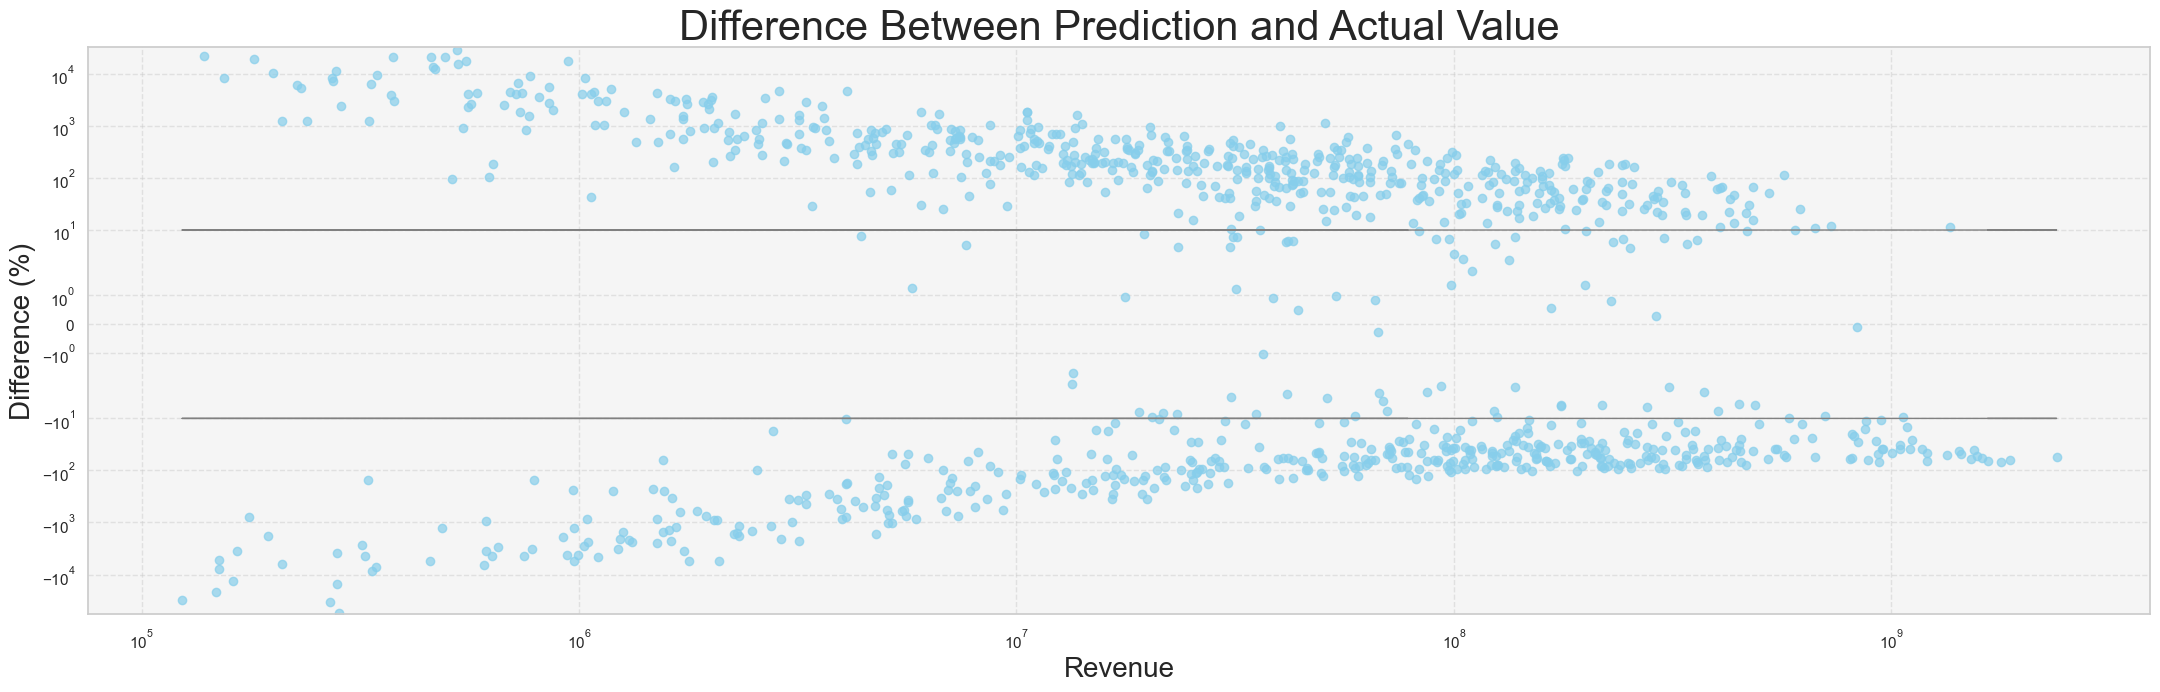

In [74]:
plt.figure(figsize=(22,7))

plt.scatter(y_test, (reg.predict(x_test_s)/(y_test)-1)*100, alpha=0.7, color='skyblue', linewidths=1)
plt.plot(y_test, [10]*len(y_test),  color="gray", lw=1)
plt.plot(y_test, [-10]*len(y_test), color="gray", lw=1)

plt.title('Difference Between Prediction and Actual Value', fontsize=30)
plt.ylabel('Difference (%)', fontsize=20)
plt.xlabel('Revenue', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.xscale('log')
plt.yscale('symlog')

plt.show()

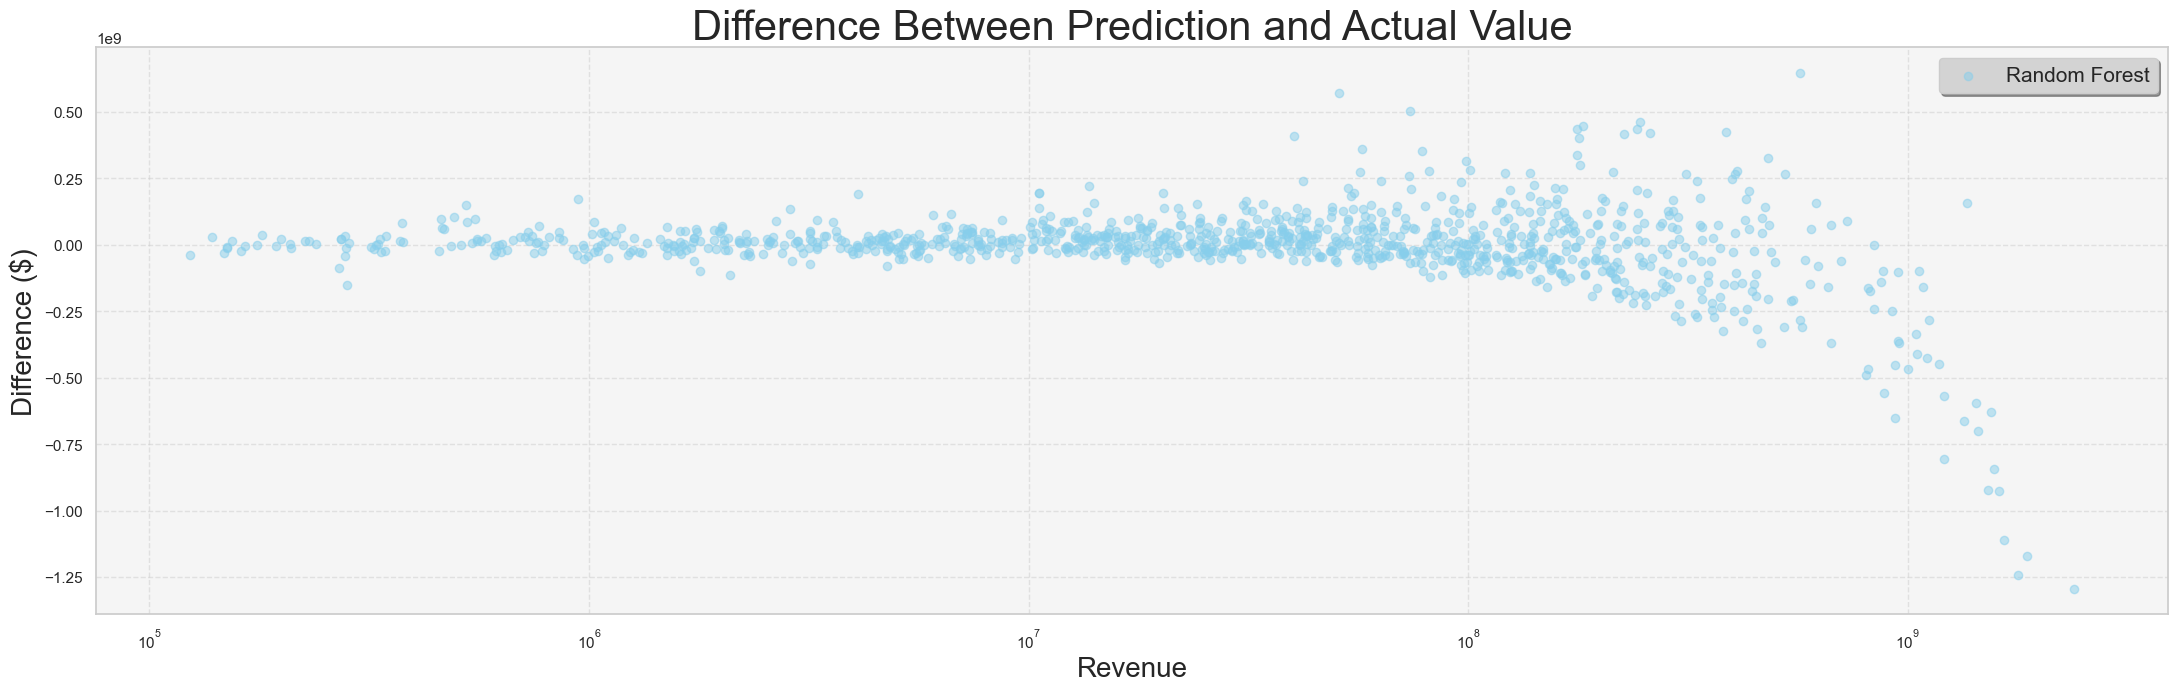

In [75]:
plt.figure(figsize=(22,7))

plt.scatter(y_test, reg.predict(x_test_s)-(y_test), alpha=0.5, color='skyblue', linewidths=1, label='Random Forest')


plt.title('Difference Between Prediction and Actual Value', fontsize=30)
plt.ylabel('Difference ($)', fontsize=20)
plt.xlabel('Revenue', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.xscale('log')

plt.legend(fontsize=15, shadow=True, facecolor='lightgray')

plt.show()

# 

## Random Forest Algorithm

In [76]:
forest = RandomForestRegressor()

param_grid = {
    "n_estimators": [250], 
    "min_samples_split": [6],
    "max_features": ["sqrt", "log2"],    
}

gris_search = GridSearchCV(forest, param_grid, scoring='neg_mean_squared_error', return_train_score=True, cv=5)

gris_search.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [6], 'n_estimators': [250]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [77]:
best_forest = gris_search.best_estimator_
print(best_forest)

RandomForestRegressor(max_features='log2', min_samples_split=6,
                      n_estimators=250)


In [78]:
best_forest.score(x_test_s,y_test)

0.676228229919922

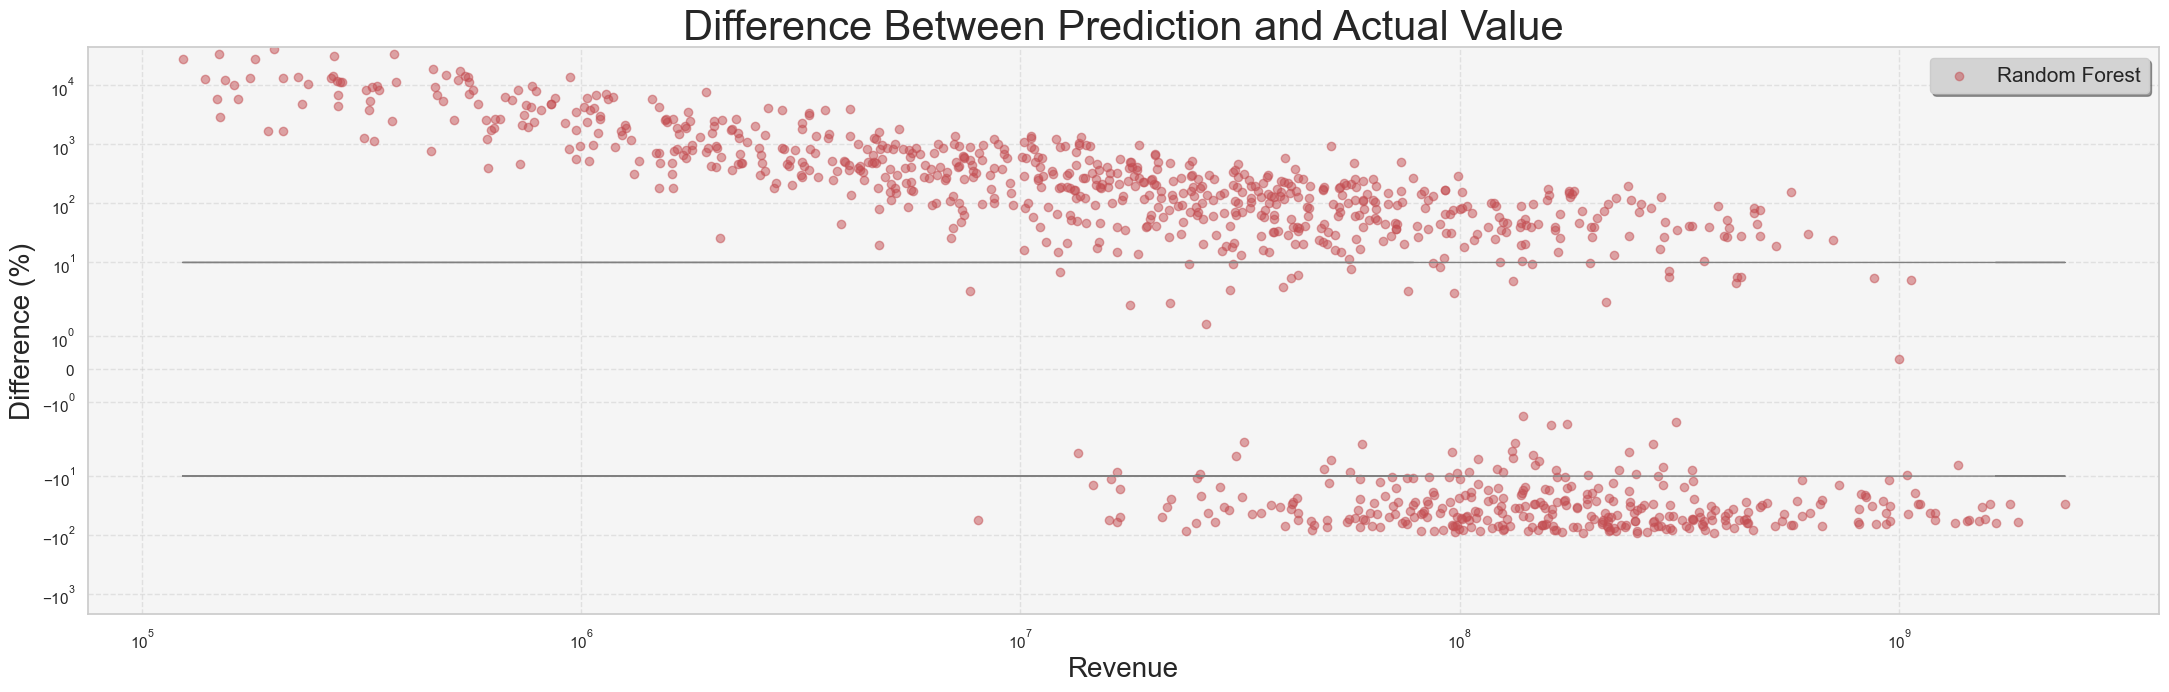

In [79]:
plt.figure(figsize=(22,7))

plt.scatter(y_test, (best_forest.predict(x_test_s)/(y_test)-1)*100, alpha=0.5, color='r', linewidths=1, label='Random Forest')

plt.plot(y_test, [10]*len(y_test),  color="gray", lw=1)
plt.plot(y_test, [-10]*len(y_test), color="gray", lw=1)


plt.title('Difference Between Prediction and Actual Value', fontsize=30)
plt.ylabel('Difference (%)', fontsize=20)
plt.xlabel('Revenue', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.xscale('log')
plt.yscale('symlog')

plt.legend(fontsize=15, shadow=True, facecolor='lightgray')

plt.show()

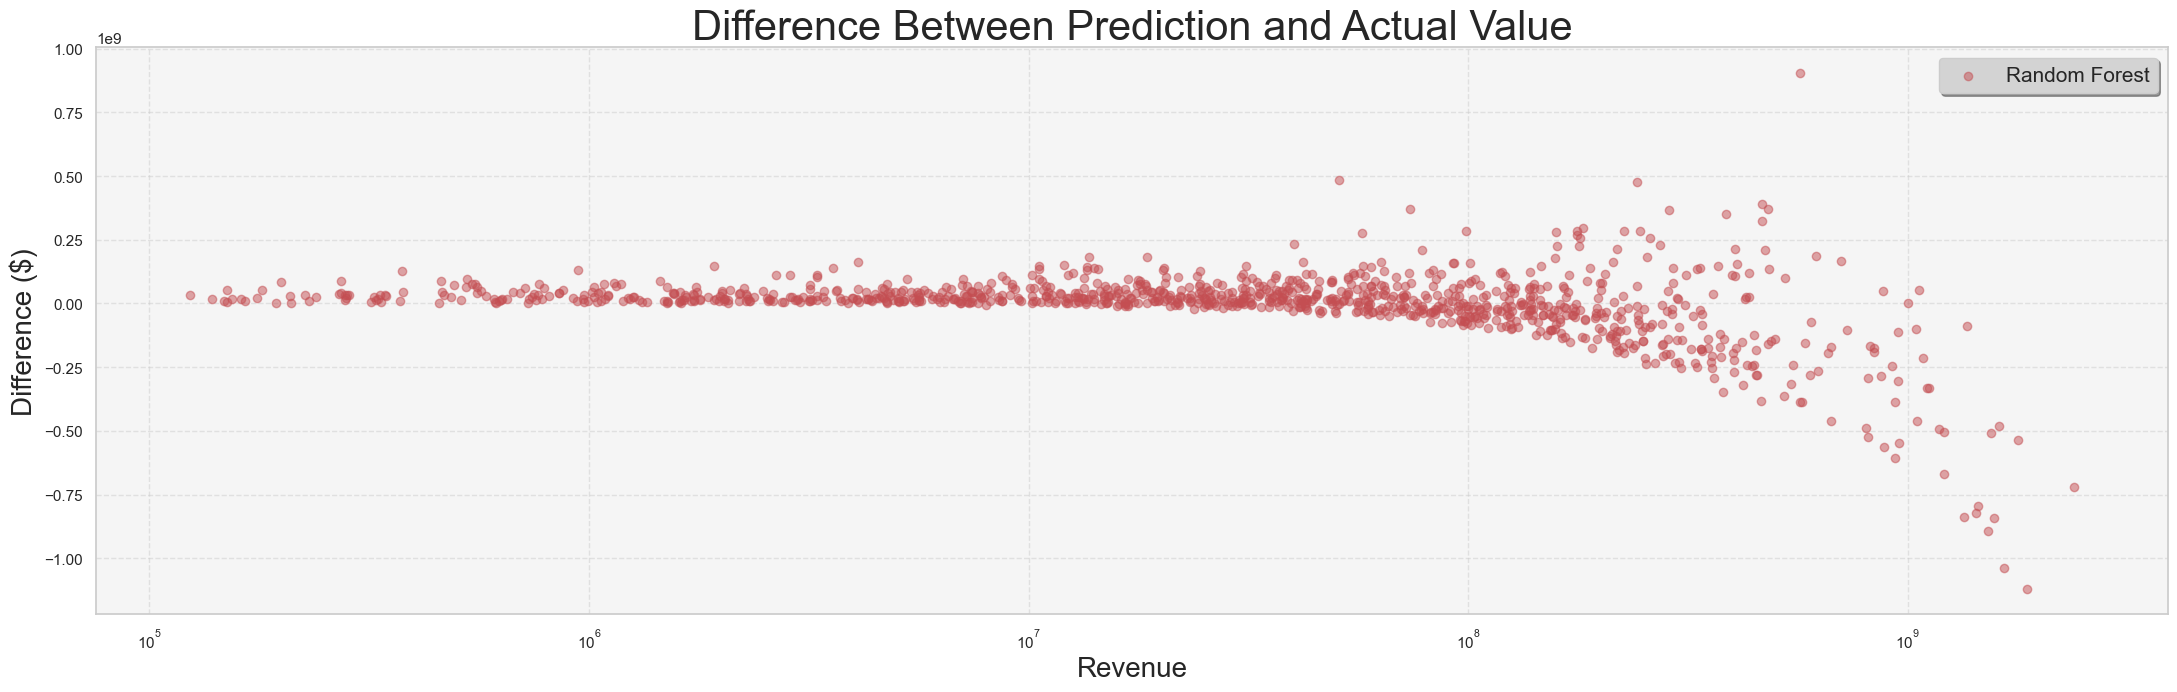

In [80]:
plt.figure(figsize=(22,7))

plt.scatter(y_test, best_forest.predict(x_test_s)-(y_test), alpha=0.5, color='r', linewidths=1, label='Random Forest')

plt.title('Difference Between Prediction and Actual Value', fontsize=30)
plt.ylabel('Difference ($)', fontsize=20)
plt.xlabel('Revenue', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.xscale('log')

plt.legend(fontsize=15, shadow=True, facecolor='lightgray')

plt.show()

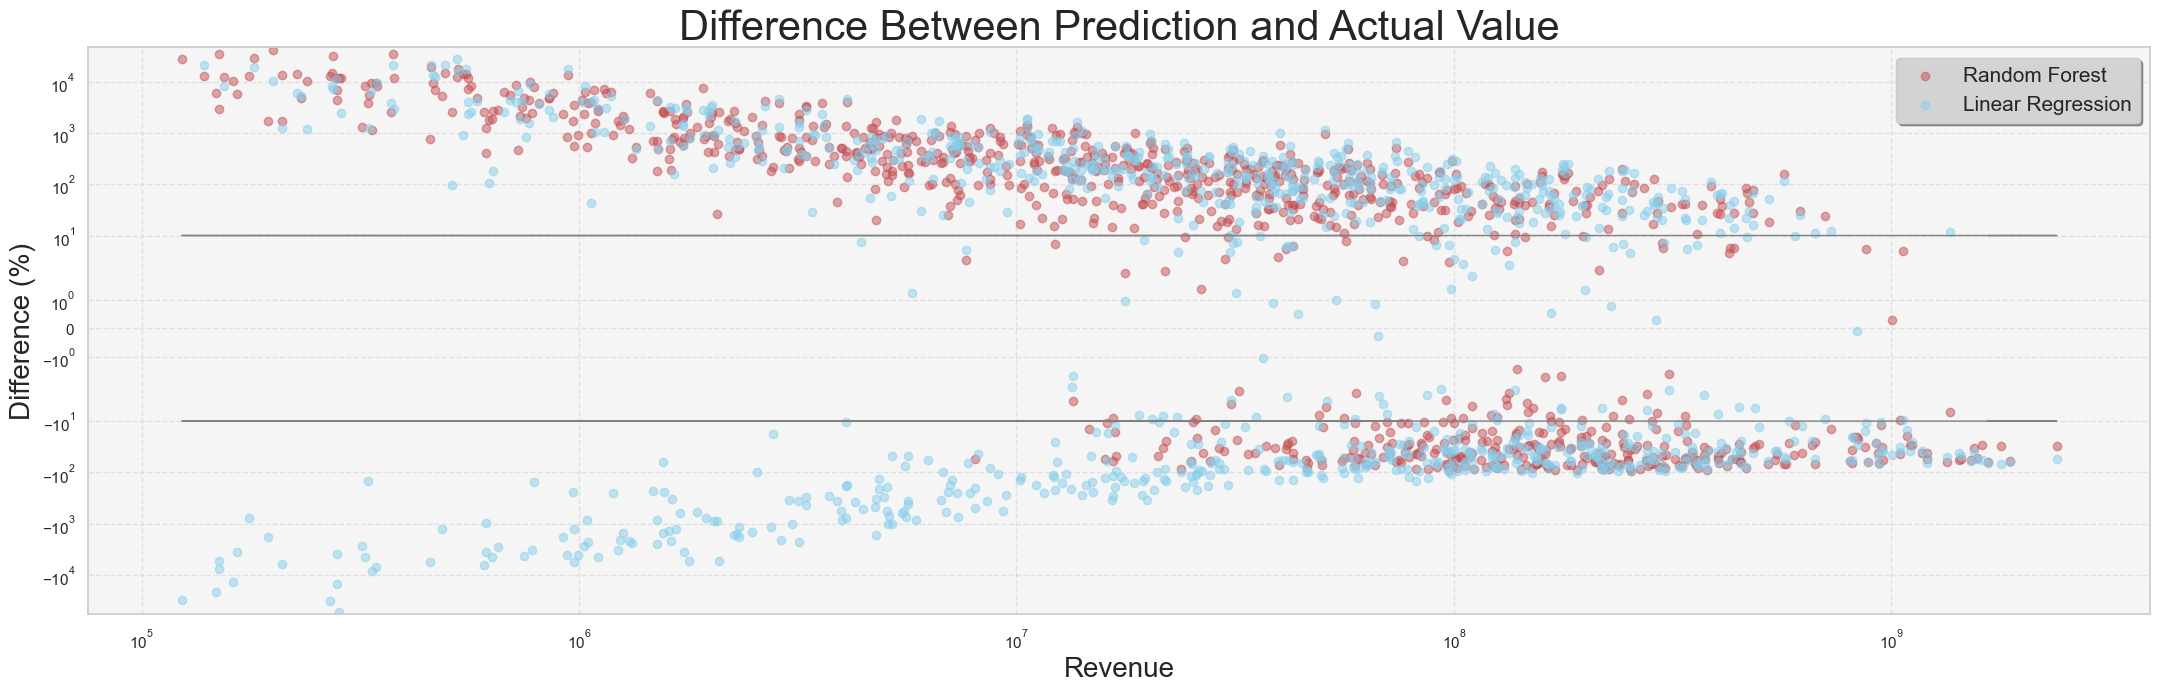

In [81]:
plt.figure(figsize=(22,7))

plt.scatter(y_test, (best_forest.predict(x_test_s)/(y_test)-1)*100, alpha=0.5, color='r', linewidths=1, label='Random Forest')
plt.scatter(y_test, (reg.predict(x_test_s)/(y_test)-1)*100, alpha=0.5, color='skyblue', linewidths=1, label='Linear Regression')

plt.plot(y_test, [10]*len(y_test),  color="gray", lw=1)
plt.plot(y_test, [-10]*len(y_test), color="gray", lw=1)


plt.title('Difference Between Prediction and Actual Value', fontsize=30)
plt.ylabel('Difference (%)', fontsize=20)
plt.xlabel('Revenue', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()

plt.xscale('log')
plt.yscale('symlog')

plt.legend(fontsize=15, shadow=True, facecolor='lightgray')

plt.show()